In [ ]:
# !pip install -U transformers

In [2]:
import torch
import numpy as np
import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import warnings
import csv
import os
warnings.filterwarnings("ignore")

# 设备配置（自动适配GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
model_path = "/kaggle/input/llama3-8b-instruct/transformers/default/1/Meta-Llama-3-8B-Instruct"

# 加载Tokenizer和Model
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    output_hidden_states=True
)
model.eval()
print("Model and Tokenizer loaded successfully!")

2025-11-05 14:52:41.369251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762354361.575721      46 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762354361.633261      46 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model and Tokenizer loaded successfully!


In [4]:
import os

# 检查文件是否存在
csv_path = "/kaggle/input/testset/testset.csv"
if not os.path.exists(csv_path):
    print(f"文件不存在！请检查路径：{csv_path}")
    print("当前目录下的文件列表：", os.listdir("/kaggle/input/testset"))  # 打印文件夹内的文件
else:
    print("文件存在，可以正常加载")

文件存在，可以正常加载


### testset

In [5]:
# 全局变量保存实验一数据
experiment1_data = {}


def save_experiment1_data(detailed_result):
    """保存实验一的hidden states数据"""
    test_id = detailed_result['test_id']
    
    # 构建保存的数据结构
    saved_data = {
        'test_id': test_id,
        'problem': detailed_result.get('problem', ''),
        'step_by_step_response': detailed_result['step_by_step_response'],
        'step_data': [],
        'skipping_info': detailed_result['skipping_info'],
        'all_skip_results': detailed_result['all_skip_results'],
        'hidden_states_info': {
            'total_steps': len(detailed_result.get('step_data', [])),
            'has_skipped_steps': len(detailed_result['skipping_info']['skipped_steps']) > 0,
            'saved_timestamp': str(np.datetime64('now')),
            'target_layer': -1  # 新增：记录提取隐藏状态的层（-1表示最后一层）
        }
    }
    
    # 保存步骤数据（包括hidden states和layer_idx）
    for step in detailed_result.get('step_data', []):
        step_data_copy = step.copy()
        # 确保hidden state是numpy数组
        if 'hidden_state' in step_data_copy:
            step_data_copy['hidden_state'] = step_data_copy['hidden_state']
        # 新增：保存层索引（与实验三Tuned Lens匹配）
        step_data_copy['layer_idx'] = step.get('layer_idx', -1)
        saved_data['step_data'].append(step_data_copy)
    
    # 保存到全局变量
    experiment1_data[test_id] = saved_data
    
    # 保存到文件
    filename = f"experiment1_hidden_states_{test_id}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(saved_data, f)
    
    # 打印保存信息
    print(f"✓ 已保存 {test_id} 的hidden states数据到 {filename}")
    print(f"  - 步骤数量: {len(saved_data['step_data'])}")
    print(f"  - 跳步数量: {len(saved_data['skipping_info']['skipped_steps'])}")
    if saved_data['step_data']:
        print(f"  - hidden state形状: {saved_data['step_data'][0]['hidden_state'].shape}")
        print(f"  - 提取层索引: {saved_data['step_data'][0]['layer_idx']}")  # 新增：打印层索引

def save_complete_experiment1_data():
    """保存完整的实验一数据集"""
    if experiment1_data:
        with open("experiment1_complete_data.pkl", 'wb') as f:
            pickle.dump(experiment1_data, f)
        print(f"\n🎉 已保存完整的实验一数据，共 {len(experiment1_data)} 个测试案例")
        return True
    else:
        print("❌ 没有实验数据可保存")
        return False

def summarize_experiment1_data():
    """汇总实验一数据"""
    print("\n" + "="*60)
    print("实验一数据汇总")
    print("="*60)
    
    if not experiment1_data:
        print("暂无实验数据")
        return
    
    for test_id, data in experiment1_data.items():
        print(f"\n{test_id}:")
        print(f"  问题: {data['problem'][:100]}...")
        print(f"  推理步骤: {len(data['step_data'])}")
        print(f"  跳步: {len(data['skipping_info']['skipped_steps'])}")
        print(f"  跳步详情: {data['skipping_info']['skipped_steps']}")
        if data['step_data']:
            print(f"  提取层索引: {data['step_data'][0]['layer_idx']}")  # 新增：显示层索引

def calculate_similarity_between_paths(actual_skip_hidden, generated_paths_hidden_states):
    """
    计算实际跳步hidden states与生成路径hidden states的相似度
    
    Args:
        actual_skip_hidden: 实际跳步步骤的hidden state (numpy array)
        generated_paths_hidden_states: 生成的各路径hidden states列表
    
    Returns:
        similarities: 各路径的相似度列表
    """
    similarities = []
    actual_vector = actual_skip_hidden.reshape(1, -1)
    
    for path_hidden in generated_paths_hidden_states:
        if path_hidden is not None:
            path_vector = path_hidden.reshape(1, -1)
            sim = cosine_similarity(actual_vector, path_vector)[0][0]
            similarities.append(float(sim))
        else:
            similarities.append(0.0)
    
    return similarities

def get_actual_skip_hidden_state(skip_step_key, step_data, skipping_info, outputs, prompt_length):
    """
    获取实际跳步步骤的hidden state（新增layer_idx返回）
    
    Args:
        skip_step_key: 跳步的步骤key (如 'step_2')
        step_data: 步骤数据
        skipping_info: 跳步信息
        outputs: 模型输出
        prompt_length: prompt长度
    
    Returns:
        hidden_state: 跳步步骤的hidden state
        layer_idx: 对应的层索引
    """
    # 方法1: 尝试从step_data中直接找到跳步步骤
    for step in step_data:
        if step['step_number'] == skip_step_key:
            return step['hidden_state'], step.get('layer_idx', -1)  # 新增：返回layer_idx
    
    # 方法2: 如果找不到，根据跳步位置推断
    if step_data:
        return step_data[-1]['hidden_state'], step_data[-1].get('layer_idx', -1)  # 新增：返回layer_idx
    
    # 方法3: 返回整个推理的最后一个hidden state
    generated_ids = outputs.sequences[0, prompt_length:]
    layer_idx = -1  # 默认最后一层
    if len(generated_ids) > 0:
        actual_hidden_idx = prompt_length + len(generated_ids) - 1
        if actual_hidden_idx < len(outputs.hidden_states[layer_idx]):
            hidden_state = outputs.hidden_states[layer_idx][actual_hidden_idx][0, -1, :].cpu().numpy()
            return hidden_state, layer_idx
    
    return None, -1

def save_hidden_states(data_dict, filename="hidden_states_data.pkl"):
    """保存数据"""
    with open(filename, 'wb') as f:
        pickle.dump(data_dict, f)

def build_llama3_prompt(system_msg, user_msg):
    """构建符合Llama 3格式的prompt"""
    return f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system_msg}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{user_msg}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

# =====================================================
# 读取CSV测试集函数
# =====================================================
def load_testset(csv_path="/kaggle/input/testset/testset.csv"):
    """读取CSV格式的测试集"""
    testset = []
    with open(csv_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            expected_steps = row['expected_complete_reasoning'].split('||')
            testset.append({
                'id': row['id'],
                'problem': row['problem'],
                'expected_complete_reasoning': expected_steps
            })
    print(f"✓ 成功加载 {len(testset)} 个测试问题")
    return testset

# =====================================================
# 步骤级hidden states提取
# =====================================================
def extract_step_level_hidden_states(outputs, prompt_length, generated_text):
    steps = parse_step_structure(generated_text)
    step_data = []
    generated_ids = outputs.sequences[0, prompt_length:]
    full_generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    total_hidden_length = len(generated_ids)

    layer_idx = -1
    
    current_position = 0
    for step_num, step_text in steps.items():
        step_text_clean = step_text.strip()
        step_start = full_generated_text.find(step_text_clean, current_position)
        
        if step_start == -1:
            full_text_clean = " ".join(full_generated_text.split())
            step_text_clean_no_space = " ".join(step_text_clean.split())
            step_start = full_text_clean.find(step_text_clean_no_space, current_position)
            if step_start == -1:
                continue
        
        step_tokens = tokenizer.encode(step_text_clean, add_special_tokens=False)
        step_token_length = len(step_tokens)
        if step_token_length == 0:
            continue
        
        text_before_step = full_generated_text[:step_start]
        tokens_before_step = tokenizer.encode(text_before_step, add_special_tokens=False)
        step_start_token_idx = len(tokens_before_step)
        step_end_token_idx = step_start_token_idx + step_token_length - 1
        
        if step_end_token_idx < step_start_token_idx:
            current_position = step_start + len(step_text_clean)
            continue
        
        if step_end_token_idx >= total_hidden_length:
            step_end_token_idx = total_hidden_length - 1
        
        actual_hidden_idx = prompt_length + step_end_token_idx
        if actual_hidden_idx >= len(outputs.hidden_states[-1]):
            actual_hidden_idx = len(outputs.hidden_states[-1]) - 1
        step_hidden = outputs.hidden_states[-1][actual_hidden_idx][0, -1, :].cpu().numpy()
        
        step_data.append({
            'step_number': step_num,
            'step_text': step_text,
            'hidden_state': step_hidden,
            'layer_idx': layer_idx, 
            'token_start': step_start_token_idx,
            'token_end': step_end_token_idx,
            'token_length': step_token_length,
            'text_position': step_start
        })
        
        current_position = step_start + len(step_text_clean)
    
    if not step_data and len(generated_ids) > 0:
        actual_hidden_idx = prompt_length + len(generated_ids) - 1
        if actual_hidden_idx >= len(outputs.hidden_states[-1]):
            actual_hidden_idx = len(outputs.hidden_states[-1]) - 1
        last_hidden = outputs.hidden_states[-1][actual_hidden_idx][0, -1, :].cpu().numpy()
        step_data.append({
            'step_number': 'step_1',
            'step_text': generated_text,
            'hidden_state': last_hidden,
            'layer_idx': layer_idx, 
            'token_start': 0,
            'token_end': len(generated_ids) - 1,
            'token_length': len(generated_ids),
            'text_position': 0
        })
    
    return step_data

def parse_step_structure(text):
    steps = {}
    step_patterns = [
        r'(Step\s*\d+\s*:)(.*?)(?=Step\s*\d+\s*:|Final Answer:|$)',
        r'(\d+\.\s*)(.*?)(?=\d+\.\s*|Final Answer:|$)',
        r'(\d+\)\s*)(.*?)(?=\d+\)\s*|Final Answer:|$)',
        r'(Final Answer:\s*)(.*?)(?=$)'
    ]
    
    all_matches = []
    for pattern in step_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE | re.DOTALL)
        for match in matches:
            header, content = match[0], match[1]
            start_pos = text.find(header)
            if start_pos != -1:
                all_matches.append((start_pos, header.strip(), content.strip()))
    
    all_matches.sort(key=lambda x: x[0])
    
    for i, (pos, header, content) in enumerate(all_matches):
        if not content:
            continue
        if "final" in header.lower() or "answer" in header.lower():
            step_key = "final"
        else:
            step_key = f"step_{i+1}"
        step_text = f"{header} {content}".strip()
        steps[step_key] = step_text
    
    if len(steps) <= 1:
        steps = heuristic_step_splitting(text)
    
    return steps

def heuristic_step_splitting(text):
    steps = {}
    lines = text.split('\n')
    step_count = 1
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if (re.match(r'^\d+\.', line) or 
            re.match(r'^Step\s*\d+', line, re.I) or
            re.match(r'^\d+\)', line) or
            len(line) > 20 and any(keyword in line.lower() for keyword in ['first', 'then', 'next', 'after', 'finally'])):
            if 'final' not in line.lower() and 'answer' not in line.lower():
                steps[f'step_{step_count}'] = line
                step_count += 1
            else:
                steps['final'] = line
    
    if len(steps) <= 1:
        sentences = re.split(r'[.!?]+', text)
        for sentence in sentences:
            sentence = sentence.strip()
            if len(sentence) > 15 and not sentence.startswith(('So', 'Therefore', 'Thus')):
                if step_count <= 4:
                    steps[f'step_{step_count}'] = sentence
                    step_count += 1
    
    return steps

# =====================================================
# 跳步识别函数
# =====================================================
def identify_skipped_steps(step_by_step_response, problem, expected_complete_reasoning):
    judge_prompt = build_llama3_prompt(
        "You are a strict but reasonable reasoning analyzer. Focus on comparing actual reasoning with expected core logic step by step. Missing any expected core logic = skipped step. Wording differences are acceptable if core logic is fully included.",
        f"""Problem: {problem}

Expected Complete Reasoning (EACH STEP'S CORE LOGIC IS MANDATORY):
{chr(10).join([f"Expected Step {i+1}: {step.strip()}" for i, step in enumerate(expected_complete_reasoning)])}

Actual Reasoning:
{step_by_step_response}

Strict Rules:
1. For Step 1: Only judge if the core logic matches the expected Step 1 (wording differences are acceptable as long as the key meaning is the same).
2. For Steps 2+: Compare actual reasoning with EVERY expected step's core logic (ignore wording/format differences ONLY if core logic is fully included).
3. If ANY expected core logic is not found in actual reasoning → mark as skipped step.
4. For incomplete problems (actual reasoning asks for more info), mark SKIPPED_STEPS as "incomplete_problem", not "none".
5. Do NOT use "none" if actual reasoning is incomplete or missing expected logic.

Must output in this EXACT format (no extra words):
SKIPPED_STEPS: [step numbers separated by commas / "incomplete_problem" / "none" only if 100% complete]
SKIPPED_CONTENT: [missing core logic / "incomplete_problem" / "none"]
SKIPPING_LOCATION: [between step X and step Y / "incomplete_problem" / "none"]"""
    )
    
    inputs = tokenizer(judge_prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=200,  # 加长输出，适配多跳步描述
            num_return_sequences=1,
            do_sample=False,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    judge_response = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    judge_analysis = judge_response.split("assistant")[-1].strip() if "assistant" in judge_response else judge_response
    skipping_info = parse_skipping_analysis(judge_analysis)
    return skipping_info, judge_analysis

def parse_skipping_analysis(analysis_text):
    skipping_info = {
        'skipped_steps': [],
        'skipped_content': '',
        'skipping_location': '',
        'from_step': None,
        'to_step': None
    }
    
    # 提取所有跳步序号（核心修复：支持多跳步识别）
    steps_match = re.search(r'SKIPPED_STEPS:\s*([^\n]+)', analysis_text)
    if steps_match:
        steps_str = steps_match.group(1).strip()
        if steps_str != "none" and steps_str != "incomplete_problem":
            step_numbers = re.findall(r'\d+', steps_str)
            skipping_info['skipped_steps'] = [f"step_{num}" for num in step_numbers]
    
    # 提取缺失内容（适配多跳步的缺失描述）
    content_match = re.search(r'SKIPPED_CONTENT:\s*([^\n]+)', analysis_text)
    if content_match:
        skipping_info['skipped_content'] = content_match.group(1).strip()
    
    # 提取跳步位置
    location_match = re.search(r'SKIPPING_LOCATION:\s*([^\n]+)', analysis_text)
    if location_match:
        location_str = location_match.group(1).strip()
        skipping_info['skipping_location'] = location_str
        step_matches = re.findall(r'step\s*(\d+)', location_str.lower())
        if len(step_matches) >= 2:
            skipping_info['from_step'] = f"step_{step_matches[0]}"
            skipping_info['to_step'] = f"step_{step_matches[1]}"
    
    return skipping_info

# =====================================================
# LLM对比路径生成（修复版）
# =====================================================
def generate_comparison_paths_with_llm_fixed(skipping_info, step_data, problem, tokenizer, model, outputs, prompt_length):
    """
    修复版的对比路径生成函数，正确计算相似度
    """
    # 获取当前跳步信息
    skipped_step_key = skipping_info['current_skip_step']
    skipped_num = int(skipped_step_key.split('_')[1])
    
    # 关键修复：接收hidden_state和layer_idx两个返回值
    actual_skip_hidden, _ = get_actual_skip_hidden_state(
        skipped_step_key, step_data, skipping_info, outputs, prompt_length
    )
    
    if actual_skip_hidden is None:
        return {
            "status": "error", 
            "error": "无法获取实际跳步的hidden state",
            "similarities": {},
            "paths": {}
        }
    
    # 上下文构建
    prev_step_key = f"step_{skipped_num - 1}" if skipped_num > 1 else "problem"
    target_step_key = f"step_{skipped_num + 1}" if skipped_num + 1 <= len(step_data) else None

    if prev_step_key == "problem":
        prev_text = f"Problem: {problem}"
    else:
        prev_text = next((step['step_text'].strip() for step in step_data if step['step_number'] == prev_step_key), "")
    
    target_text = next((step['step_text'].strip() for step in step_data if step['step_number'] == target_step_key), "Final reasoning step")

    context_text = f"""You need to补充 the skipped reasoning step (Step {skipped_num}) between:
Previous context: {prev_text}
Next step (target): {target_text}
Mandatory missing content to include: {skipping_info['skipped_content']}
Please output ONLY the reasoning step, no extra words, no greetings, no explanations."""

    style_prompts = {
        "detailed": "Provide a detailed reasoning step (include all missing content):",
        "shortcut": "Give a direct reasoning step (only core missing content, no extra words):",
        "alternative": "Provide an alternative concise reasoning step (include missing content):"
    }

    results = {
        "status": "ok", 
        "actual_skip_hidden_shape": actual_skip_hidden.shape,
        "similarities": {}, 
        "paths": {},
        "generated_hidden_states": {}
    }

    for style, prompt_suffix in style_prompts.items():
        sims = []
        path_texts = []
        generated_hiddens = []
        
        for _ in range(3):  # 每个风格生成3个样本
            user_msg = f"{context_text}\n\n{prompt_suffix}"
            full_prompt = build_llama3_prompt(
                "You are a precise reasoning assistant. Only output the required reasoning step, no extra content.", 
                user_msg
            )

            inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True).to(model.device)
            with torch.no_grad():
                path_outputs = model.generate(
                    **inputs,
                    max_new_tokens=120,
                    do_sample=True,
                    output_hidden_states=True,
                    return_dict_in_generate=True,
                    pad_token_id=tokenizer.eos_token_id
                )

            # 解码路径文本
            generated_ids = path_outputs.sequences[0, len(inputs.input_ids[0]):]
            path_text = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            
            # 过滤无效回复
            if any(word in path_text.lower() for word in ["help", "context", "provide", "missing", "information"]):
                path_text = f"[Invalid: Did not include missing content]"
            path_texts.append(path_text)

            # 获取生成路径的hidden state（最后一个token的hidden state）
            if len(path_outputs.hidden_states) > 0 and len(path_outputs.hidden_states[-1]) > 0:
                path_hidden = path_outputs.hidden_states[-1][-1][0, -1, :].cpu().numpy()
                generated_hiddens.append(path_hidden)
            else:
                generated_hiddens.append(None)

        # 计算相似度：实际跳步 vs 生成路径
        if generated_hiddens and any(h is not None for h in generated_hiddens):
            sims = calculate_similarity_between_paths(actual_skip_hidden, generated_hiddens)
        else:
            sims = [0.0, 0.0, 0.0]

        results["similarities"][style] = {
            "mean": float(np.mean(sims)),
            "std": float(np.std(sims)),
            "all": sims
        }
        results["paths"][style] = path_texts
        results["generated_hidden_states"][style] = generated_hiddens

    return results

# =====================================================
# 单个问题实验流程（包含数据保存）
# =====================================================
def main_experiment_with_save(test_sample):
    """修改版的实验一流程，包含数据保存"""
    test_id = test_sample['id']
    problem = test_sample['problem']
    expected_steps = test_sample['expected_complete_reasoning']
    
    # 生成分步推理
    step_by_step_prompt = build_llama3_prompt(
        "You solve reasoning problems in a FIXED FORMAT. Follow EXACTLY: 1. Start with 'Step 1: ...' 2. Each step has only core logic 3. End with 'Final Answer: ...' 4. No extra greetings/explanations 5. Do NOT ask for more information (try your best if problem is simple)",
        f"Problem: {problem}\n\nSolve step by step in the FIXED FORMAT (only core logic, no extra words):"
    )
    inputs = tokenizer(step_by_step_prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            num_return_sequences=1,
            do_sample=True,
            output_hidden_states=True,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.eos_token_id
        )
    full_response = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    step_by_step_response = full_response.split("assistant")[-1].strip() if "assistant" in full_response else full_response
    
    # 提取步骤级hidden states
    prompt_length = inputs.input_ids.shape[1]
    step_data = extract_step_level_hidden_states(outputs, prompt_length, step_by_step_response)
    
    # 识别跳步位置
    skipping_info, judge_analysis = identify_skipped_steps(step_by_step_response, problem, expected_steps)
    
    # 为每个跳步生成对比路径
    all_skip_results = []
    if skipping_info['skipped_steps']:
        for skip_step in skipping_info['skipped_steps']:
            single_skip_info = {
                'current_skip_step': skip_step,
                'skipped_content': skipping_info['skipped_content'],
                'skipping_location': skipping_info['skipping_location']
            }
            comparison_results = generate_comparison_paths_with_llm_fixed(
                single_skip_info, 
                step_data, 
                problem,
                tokenizer, 
                model,
                outputs,
                prompt_length
            )
            all_skip_results.append({
                'skip_step': skip_step,
                'similarity_results': comparison_results.get('similarities', {}),
                'paths': comparison_results.get('paths', {}),
                'actual_hidden_shape': comparison_results.get('actual_skip_hidden_shape', 'unknown'),
                'status': comparison_results.get('status', 'unknown')
            })
    
    # 构建完整结果
    result = {
        'test_id': test_id,
        'problem': problem,
        'step_by_step_response': step_by_step_response,
        'judge_analysis': judge_analysis,
        'skipping_info': skipping_info,
        'all_skip_results': all_skip_results,
        'step_data': step_data,
        'prompt_length': prompt_length
    }
    
    # 保存数据
    save_experiment1_data(result)
    
    return result

# =====================================================
# 批量运行测试集（包含数据保存）
# =====================================================
def run_experiment1_with_save():
    """运行实验一并保存所有数据"""
    testset = load_testset("/kaggle/input/testset/testset.csv")
    
    print("=" * 70)
    print(f"实验一：跳步识别与Hidden States保存 - 共 {len(testset)} 个问题")
    print("=" * 70)
    
    style_to_path = {
        "detailed": "A->C->B",
        "shortcut": "A->B",
        "alternative": "A->D->B"
    }
    
    all_results = []
    for i, test_sample in enumerate(testset):
        print(f"\n处理进度: {i+1}/{len(testset)}")
        result = main_experiment_with_save(test_sample)
        all_results.append(result)
        
        test_id = result['test_id']
        skipping_info = result['skipping_info']
        all_skip_results = result['all_skip_results']
        step_by_step_response = result['step_by_step_response']
        judge_analysis = result['judge_analysis']
        
        print(f"\n【{test_id} 详细验证】")
        print(f"模型推理过程：\n{step_by_step_response[:500]}...")
        print(f"\nLLM Judge分析：\n{judge_analysis}")
        
        # 输出所有跳步的对比路径
        if all_skip_results:
            for skip in all_skip_results:
                skip_step = skip['skip_step']
                skip_num = skip_step.split('_')[-1]
                paths = skip['paths']
                similarities = skip['similarity_results']
                
                print(f"\n【跳步{skip_num}的对比路径】")
                for style, path_texts in paths.items():
                    print(f"\n{style_to_path[style]}（{style}风格）：")
                    for i, text in enumerate(path_texts, 1):
                        print(f"  路径{i}：{text[:200]}...")  # 限制长度
                
                # 输出该跳步的最佳路径
                if similarities:
                    best_style = max(similarities.items(), key=lambda x: x[1]['mean'])[0]
                    similar_path = style_to_path[best_style]
                    best_similarity = round(similarities[best_style]['mean'], 4)
                    print(f"\n{test_id} 跳步{skip_num}: 相似路径：{similar_path} 相似度：{best_similarity}")
                else:
                    print(f"\n{test_id} 跳步{skip_num}: 相似路径：无 相似度：0.0")
        else:
            print(f"\n{test_id}: 无跳步（根据Judge分析）")
    
    # 汇总数据
    summarize_experiment1_data()
    
    # 保存完整数据集
    if save_complete_experiment1_data():
        print(f"\n📊 实验一数据统计:")
        print(f"  总测试案例: {len(experiment1_data)}")
        total_steps = sum(len(data['step_data']) for data in experiment1_data.values())
        total_skips = sum(len(data['skipping_info']['skipped_steps']) for data in experiment1_data.values())
        print(f"  总推理步骤: {total_steps}")
        print(f"  总跳步数量: {total_skips}")
    
    print(f"\n🎉 实验一完成！所有hidden states数据已保存")
    return all_results

# =====================================================
# 执行实验一（包含数据保存）
# =====================================================
if __name__ == "__main__":
    # 运行实验一并保存数据
    experiment1_results = run_experiment1_with_save()
    
    # 显示保存的文件
    print("\n📁 保存的文件列表:")
    for file in os.listdir('.'):
        if file.startswith('experiment1_') and file.endswith('.pkl'):
            file_size = os.path.getsize(file) / 1024  # KB
            print(f"  {file} ({file_size:.1f} KB)")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✓ 成功加载 8 个测试问题
实验一：跳步识别与Hidden States保存 - 共 8 个问题

处理进度: 1/8


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test1 的hidden states数据到 experiment1_hidden_states_Test1.pkl
  - 步骤数量: 6
  - 跳步数量: 1
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test1 详细验证】
模型推理过程：
Step 1: You are facing north.

Step 2: You move 5 meters forward.

Step 3: You turn 90 degrees to your right.

Step 4: You move 3 meters forward.

Step 5: You turn 90 degrees to your left.

Final Answer: You are facing east....

LLM Judge分析：
SKIPPED_STEPS: 1
SKIPPED_CONTENT: Expected Step 1: walking west
SKIPPING_LOCATION: none

【跳步1的对比路径】

A->C->B（detailed风格）：
  路径1：You enter the building from the east side, so you are initially facing west....
  路径2：You enter the building from the east side, so you are initially facing west....
  路径3：Step 1: You move 5 meters west....

A->B（shortcut风格）：
  路径1：You move 5 meters west....
  路径2：You move 10 meters west....
  路径3：You walk west....

A->D->B（alternative风格）：
  路径1：You walk west....
  路径2：Step 1: You walk west 5 meters....
  路径3：You enter the building from the east side, so you need to adjus

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test2 的hidden states数据到 experiment1_hidden_states_Test2.pkl
  - 步骤数量: 4
  - 跳步数量: 0
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test2 详细验证】
模型推理过程：
Step 1: The definition of a bachelor is a man who has never been married.

Step 2: John is a man who has never been married.

Step 3: Since John meets the definition of a bachelor, John is a bachelor.

Final Answer: Yes....

LLM Judge分析：
SKIPPED_STEPS: none
SKIPPED_CONTENT: none
SKIPPING_LOCATION: none

Test2: 无跳步（根据Judge分析）

处理进度: 3/8


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test3 的hidden states数据到 experiment1_hidden_states_Test3.pkl
  - 步骤数量: 3
  - 跳步数量: 3
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test3 详细验证】
模型推理过程：
Step 1: Factor the quadratic expression: x² – 4x + 7 = (x - 1)(x - 7)

Step 2: Find the product of the two factors: (x - 1)(x - 7) = x² - 7x + x - 7

Step 3: Combine like terms: x² - 7x + x - 7 = x² - 6x - 7

Step 4: Identify the discriminant: b² - 4ac = (-6)² - 4(1)(-7) = 36 + 28 = 64

Step 5: Since the discriminant is positive, the quadratic expression is a parabola that opens upward.

Step 6: Therefore, the quadratic expression x² – 4x + 7 is positive for all values of x....

LLM Judge分析：
SKIPPED_STEPS: 2, 3, 4
SKIPPED_CONTENT: Expected Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4 (add and subtract (4/2)² = 4 to complete the square), Expected Step 3: Simplify the expression: (x – 2)² – 4 + 7 = (x – 2)² + 3, Expected Step 4: Analyze the squared term: (x – 2)² ≥ 0 for all real x (square of any real number is non-negative)
SKIPPING_LO

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test4 的hidden states数据到 experiment1_hidden_states_Test4.pkl
  - 步骤数量: 9
  - 跳步数量: 4
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test4 详细验证】
模型推理过程：
Step 1: Consider the first few triangular numbers: T₁ = 1, T₂ = 3, T₃ = 6, T₄ = 10, T₅ = 15. Observe that each subsequent triangular number is obtained by adding the previous number plus the number of dots in the new row.

Step 2: Write the formula for the n-th triangular number as Tₙ = 1 + 2 + 3 +... + n. This is the sum of the first n natural numbers.

Step 3: Use the formula for the sum of an arithmetic series to rewrite Tₙ: Tₙ = n(n+1)/2.

Step 4: To prove the formula for the sum of cubes, c...

LLM Judge分析：
SKIPPED_STEPS: 5, 6, 7, 8
SKIPPED_CONTENT: Expected Step 5: Recall the identity that sum of first n cubes = (sum of first n integers)². Expected Step 6: Substitute sum of first n integers = Tₙ = n(n+1)/2. Expected Step 7: Square the sum: (n(n+1)/2)² = (1/4)n²(n+1)². Expected Step 8: Final Conclusion: Both formulas are proven.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test5 的hidden states数据到 experiment1_hidden_states_Test5.pkl
  - 步骤数量: 7
  - 跳步数量: 0
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test5 详细验证】
模型推理过程：
Step 1: Let the total amount of money Jane won be x.

Step 2: The amount spent on the first day is $1.50, so the amount left is x - $1.50.

Step 3: The amount spent on the second day is $3, so the amount left is (x - $1.50) - $3.

Step 4: The amount spent on the third day is $4.50, so the amount left is ((x - $1.50) - $3) - $4.50.

Step 5: The pattern continues, so the amount spent on the last day is $1.50 + $3 + $4.50 = $9, so the amount left is (((x - $1.50) - $3) - $4.50) - $9.

Step 6: The a...

LLM Judge分析：
SKIPPED_STEPS: none
SKIPPED_CONTENT: none
SKIPPING_LOCATION: none

Test5: 无跳步（根据Judge分析）

处理进度: 6/8


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test6 的hidden states数据到 experiment1_hidden_states_Test6.pkl
  - 步骤数量: 3
  - 跳步数量: 0
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test6 详细验证】
模型推理过程：
Step 1: Alabama's capital is Montgomery.

Step 2: The state capital is not mentioned in the given options.

Final Answer: There is no other state capital mentioned in the options....

LLM Judge分析：
SKIPPED_STEPS: none
SKIPPED_CONTENT: none
SKIPPING_LOCATION: none

Test6: 无跳步（根据Judge分析）

处理进度: 7/8


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test7 的hidden states数据到 experiment1_hidden_states_Test7.pkl
  - 步骤数量: 6
  - 跳步数量: 1
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test7 详细验证】
模型推理过程：
Step 1: Notice that 33ⁿ - 16ⁿ - 28ⁿ + 11ⁿ can be written as (33ⁿ - 16ⁿ) - (28ⁿ - 11ⁿ).

Step 2: Observe that 33ⁿ - 16ⁿ = (33 - 16)ⁿ = 17ⁿ.

Step 3: Similarly, 28ⁿ - 11ⁿ = (28 - 11)ⁿ = 17ⁿ.

Step 4: Hence, 33ⁿ - 16ⁿ - 28ⁿ + 11ⁿ = 17ⁿ - 17ⁿ = 0.

Step 5: Since 0 is divisible by any integer, 33ⁿ - 16ⁿ - 28ⁿ + 11ⁿ is divisible by 85.

Final Answer: 85....

LLM Judge分析：
SKIPPED_STEPS: 1
SKIPPED_CONTENT: Expected Step 1: Factor 85 into prime factors: 85 = 5 × 17 (coprime
SKIPPING_LOCATION: Step 1

【跳步1的对比路径】

A->C->B（detailed风格）：
  路径1：Step 1: 85 = 5 × 17, which are coprime....
  路径2：Step 1: 85 = 5 × 17....
  路径3：Step 1: 85 = 5 × 17, where 5 and 17 are coprime....

A->B（shortcut风格）：
  路径1：85 = 5 × 17...
  路径2：85 = 5 × 17...
  路径3：85 = 5 × 17...

A->D->B（alternative风格）：
  路径1：85 = 5 × 17...
  路径2：Step 1: 85 = 5 × 17....
  路径3：Step 1: 85 = 5 

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test8 的hidden states数据到 experiment1_hidden_states_Test8.pkl
  - 步骤数量: 5
  - 跳步数量: 1
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test8 详细验证】
模型推理过程：
Step 1: I am driving.

Step 2: I am in a vehicle.

Step 3: The vehicle is moving.

Step 4: I am controlling the vehicle.

Final Answer: I am driving a vehicle....

LLM Judge分析：
SKIPPED_STEPS: 1
SKIPPED_CONTENT: Expected Step 1: and hit on the brakes
SKIPPING_LOCATION: between Step 1 and Step 2

【跳步1的对比路径】

A->C->B（detailed风格）：
  路径1：If I am driving, and hit on the brakes....
  路径2：I hit on the brakes....
  路径3：If I am driving, then I hit on the brakes....

A->B（shortcut风格）：
  路径1：I hit on the brakes....
  路径2：I hit on the brakes....
  路径3：I hit on the brakes....

A->D->B（alternative风格）：
  路径1：If I am driving, then I hit on the brakes....
  路径2：I hit on the brakes....
  路径3：I hit on the brakes....

Test8 跳步1: 相似路径：A->B 相似度：0.9145

实验一数据汇总

Test1:
  问题: If you enter a building from the east side...
  推理步骤: 6
  跳步: 1
  跳步详情: ['step_1']
 

### 方法二测试

Running Experiment 2 - Implicit Reasoning Verification via Logit Lens (Enhanced)
Experiment 2: Implicit Reasoning Verification via Logit Lens (Enhanced)
✓ Loaded experiment 1 data, total 8 test cases

Analyzing Test1
Generated step step_1 verification scenario, intermediate step: direct

  Analyzing scenario: step_1
    Target concept: opposite direction
    Intermediate step: direct
Generating complete path standard curve...
Input text: Context: Building entrance is on east side, interior is accessed from west

You enter from east side -> You move in opposite direction -> You access building interior

What directional change is neede...
Target concept 'opposite direction' token IDs: [454, 13921, 5216]
Generated probability curve: 33 layers, probability range: 0.0000-0.0002
✓ Generated complete path standard curve
Generating skip path standard curve...
Input text: Context: Building entrance is on east side, interior is accessed from west

You enter building -> You are inside

What dire

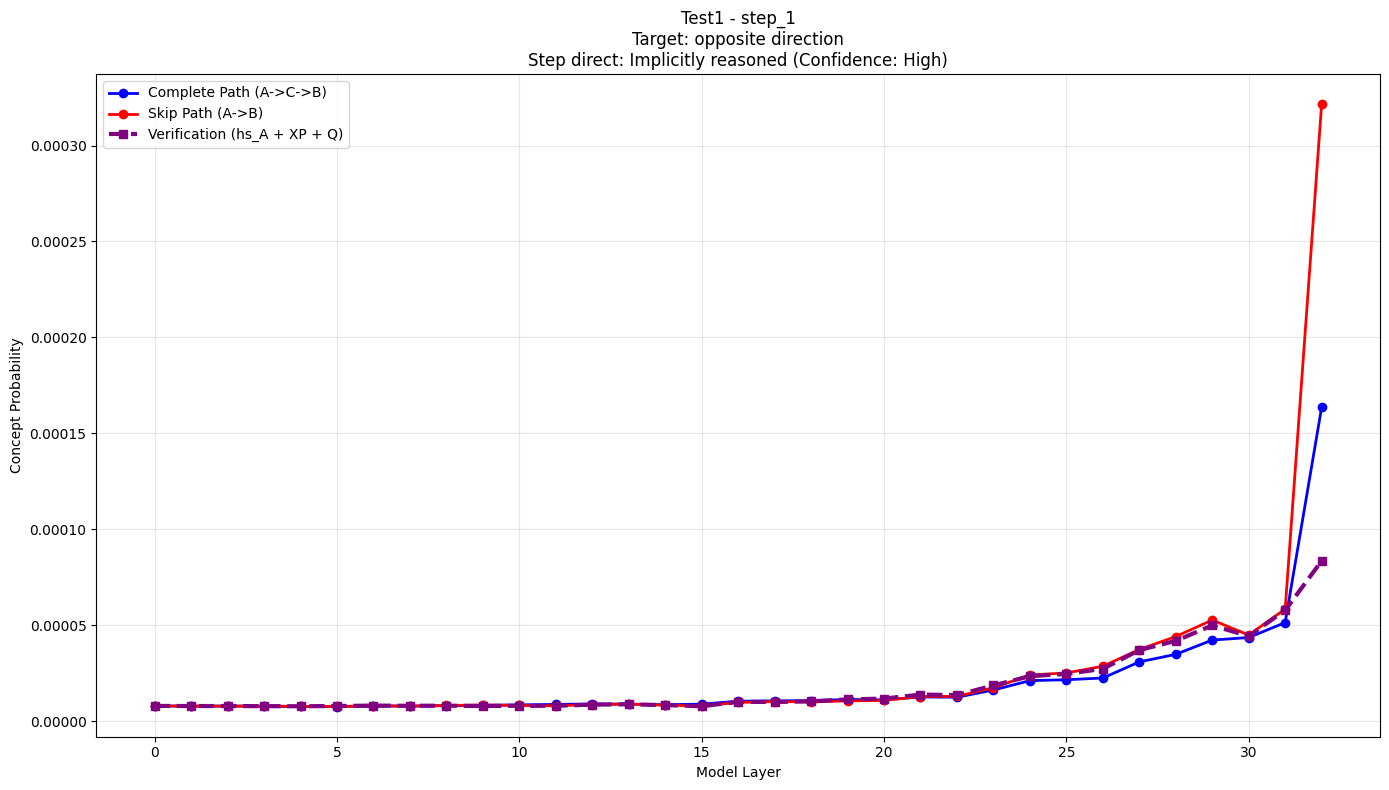


  📊 Test1 Multi-step Reasoning Analysis Summary:
    Step 1: Step direct: Implicitly reasoned (Confidence: High)

Analyzing Test2
  Test2 no skipped steps, skipping

Analyzing Test3
Generated step step_2 verification scenario, intermediate step: direct
Generated step step_3 verification scenario, intermediate step: D
Generated step step_4 verification scenario, intermediate step: direct

  Analyzing scenario: step_2
    Target concept: find factors
    Intermediate step: C
Generating complete path standard curve...
Input text: Algebraic analysis of quadratic polynomial

Quadratic polynomial -> Calculate discriminant -> Identify root pairs -> Factor expression -> Analyze solution set -> Draw conclusion

What process finds fa...
Target concept 'find factors' token IDs: [3990, 9547]
Generated probability curve: 33 layers, probability range: 0.0000-0.0002
✓ Generated complete path standard curve
Generating skip path standard curve...
Input text: Algebraic analysis of quadratic polynomial


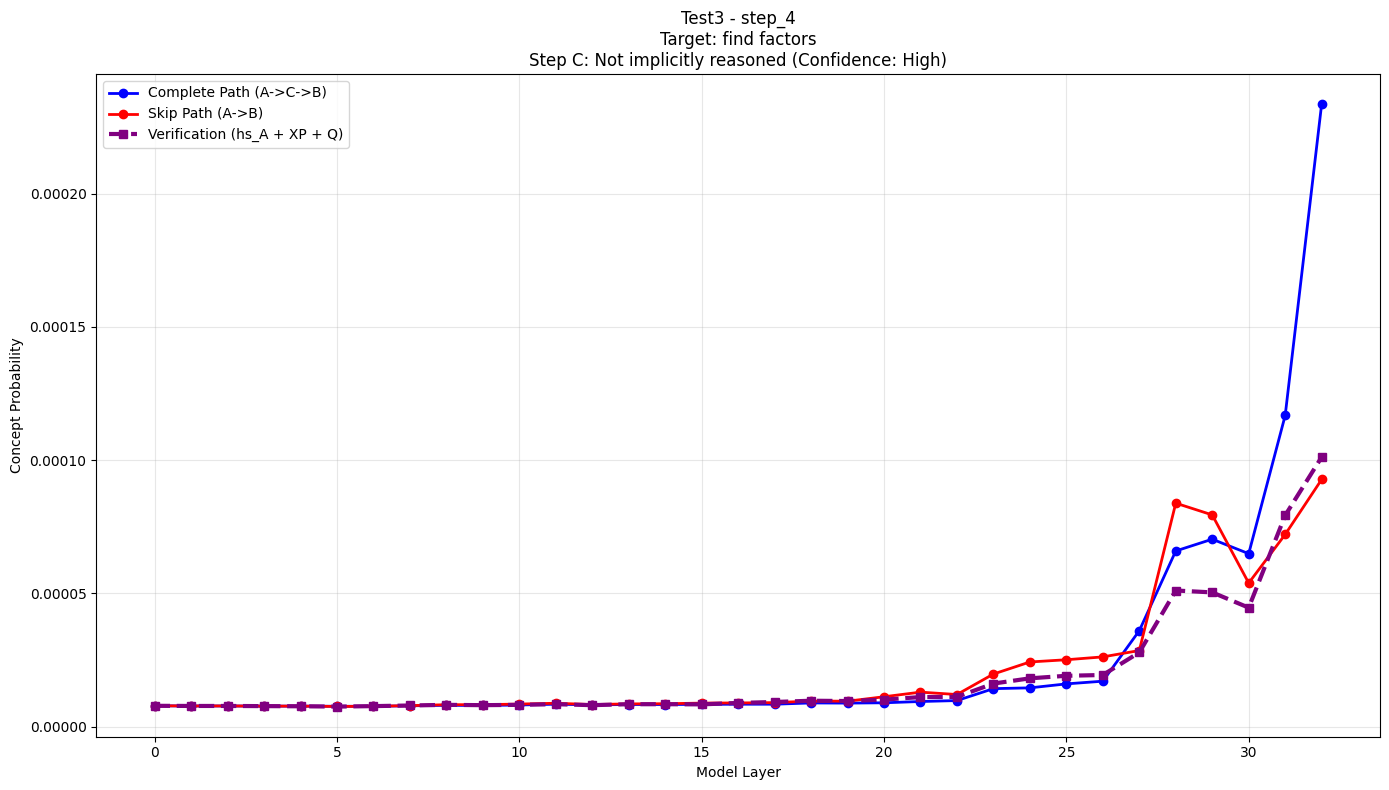


  📊 Test3 Multi-step Reasoning Analysis Summary:
    Step 1: Analysis failed
    Step 2: Analysis failed
    Step 3: Step C: Not implicitly reasoned (Confidence: High)

Analyzing Test4
Generated step step_5 verification scenario, intermediate step: D
Generated step step_7 verification scenario, intermediate step: D

  Analyzing scenario: step_5
    Target concept: summation formula
    Intermediate step: C
Generating complete path standard curve...
Input text: Mathematical sequence of triangular numbers

Triangular sequence -> Observe pattern -> Derive summation -> Prove formula Tₙ=n(n+1)/2 -> Apply to problem -> Verify result

What formula calculates trian...
Target concept 'summation formula' token IDs: [70644, 367, 15150]
Generated probability curve: 33 layers, probability range: 0.0000-0.0001
✓ Generated complete path standard curve
Generating skip path standard curve...
Input text: Mathematical sequence of triangular numbers

Triangular sequence -> Verify result

What formula cal

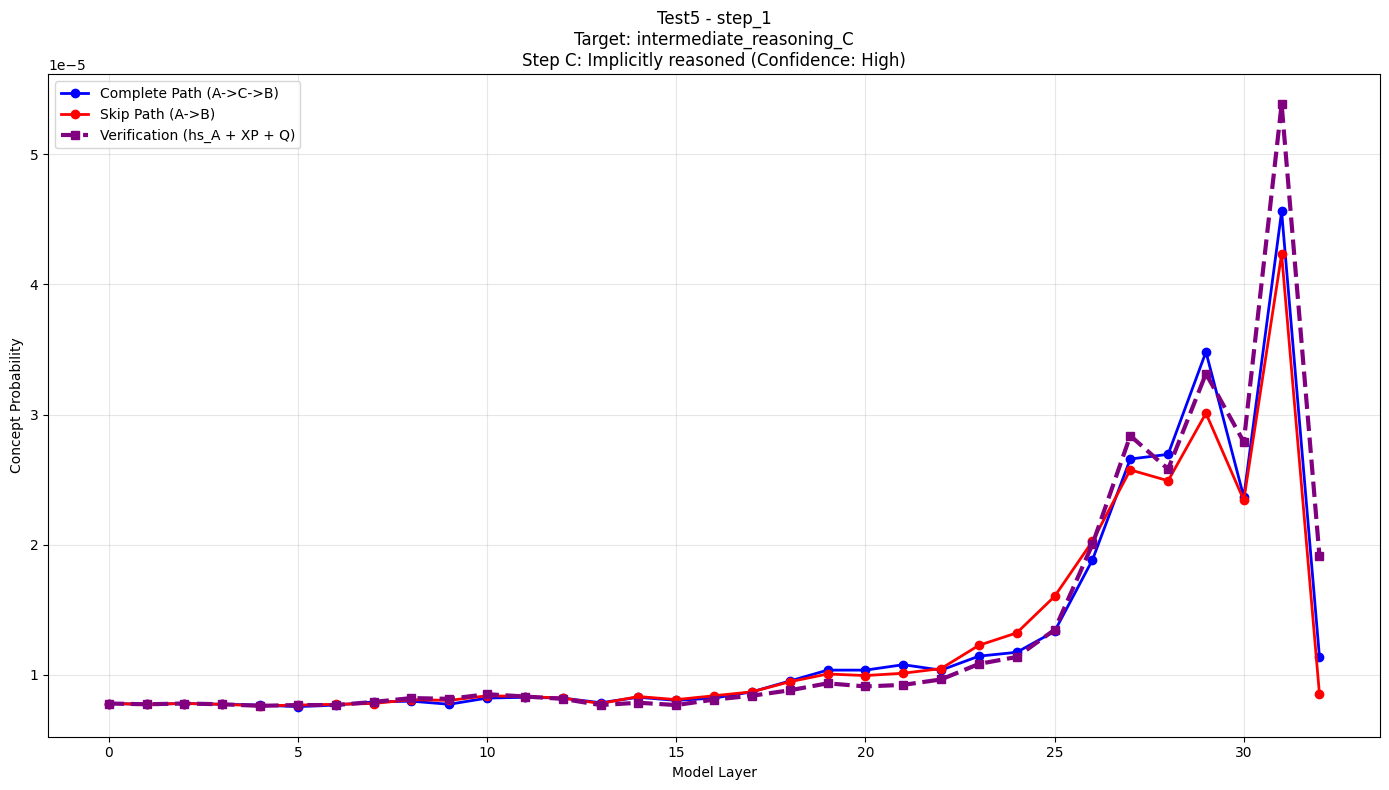


  📊 Test5 Multi-step Reasoning Analysis Summary:
    Step 1: Step C: Implicitly reasoned (Confidence: High)

Analyzing Test6
  Test6 no skipped steps, skipping

Analyzing Test7
Generated step step_1 verification scenario, intermediate step: direct

  Analyzing scenario: step_1
    Target concept: intermediate_reasoning_direct
    Intermediate step: direct
Generating complete path standard curve...
Input text: Problem context: Prove that 33ⁿ - 16ⁿ - 28ⁿ + 11ⁿ is divisible by 85 for all positive integers ≥ ...

Initial state -> Detailed step direct: Expected Step 1: Factor 85 into prime factors: 85 ... -> Mu...
Target concept 'intermediate_reasoning_direct' token IDs: [2295, 14978, 39329, 287, 33971]
Generated probability curve: 33 layers, probability range: 0.0000-0.0000
✓ Generated complete path standard curve
Generating skip path standard curve...
Input text: Problem context: Prove that 33ⁿ - 16ⁿ - 28ⁿ + 11ⁿ is divisible by 85 for all positive integers ≥ ...

Initial state -> Final c

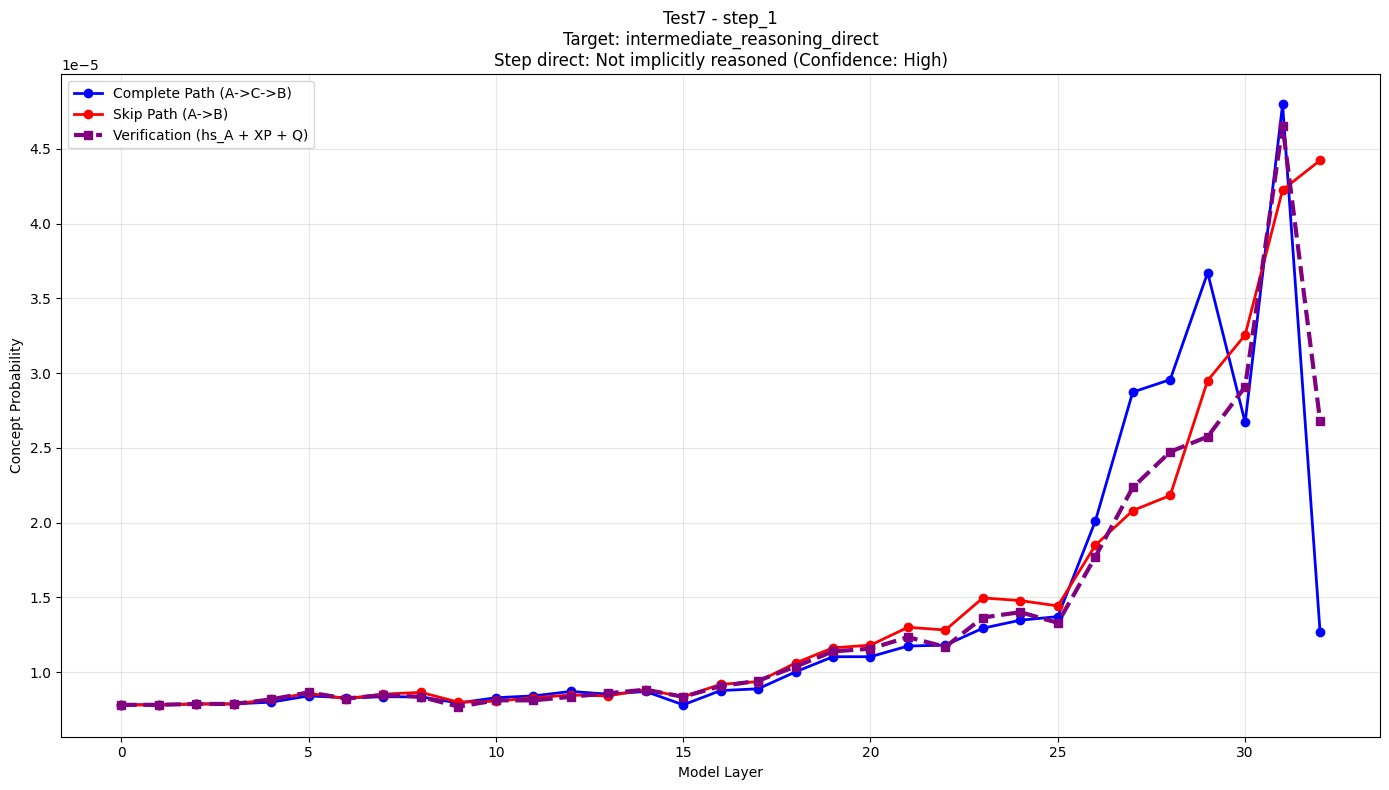


  📊 Test7 Multi-step Reasoning Analysis Summary:
    Step 1: Step direct: Not implicitly reasoned (Confidence: High)

Analyzing Test8
Generated step step_1 verification scenario, intermediate step: direct

  Analyzing scenario: step_1
    Target concept: intermediate_reasoning_direct
    Intermediate step: direct
Generating complete path standard curve...
Input text: Problem context: If I am driving...

Initial state -> Detailed step direct: Expected Step 1: and hit on the brakes... -> Multiple verifications -> Final conclusion

What reasoning occurs in intermedia...
Target concept 'intermediate_reasoning_direct' token IDs: [2295, 14978, 39329, 287, 33971]
Generated probability curve: 33 layers, probability range: 0.0000-0.0001
✓ Generated complete path standard curve
Generating skip path standard curve...
Input text: Problem context: If I am driving...

Initial state -> Final conclusion

What reasoning occurs in intermediate step direct?...
Target concept 'intermediate_reasoning_dire

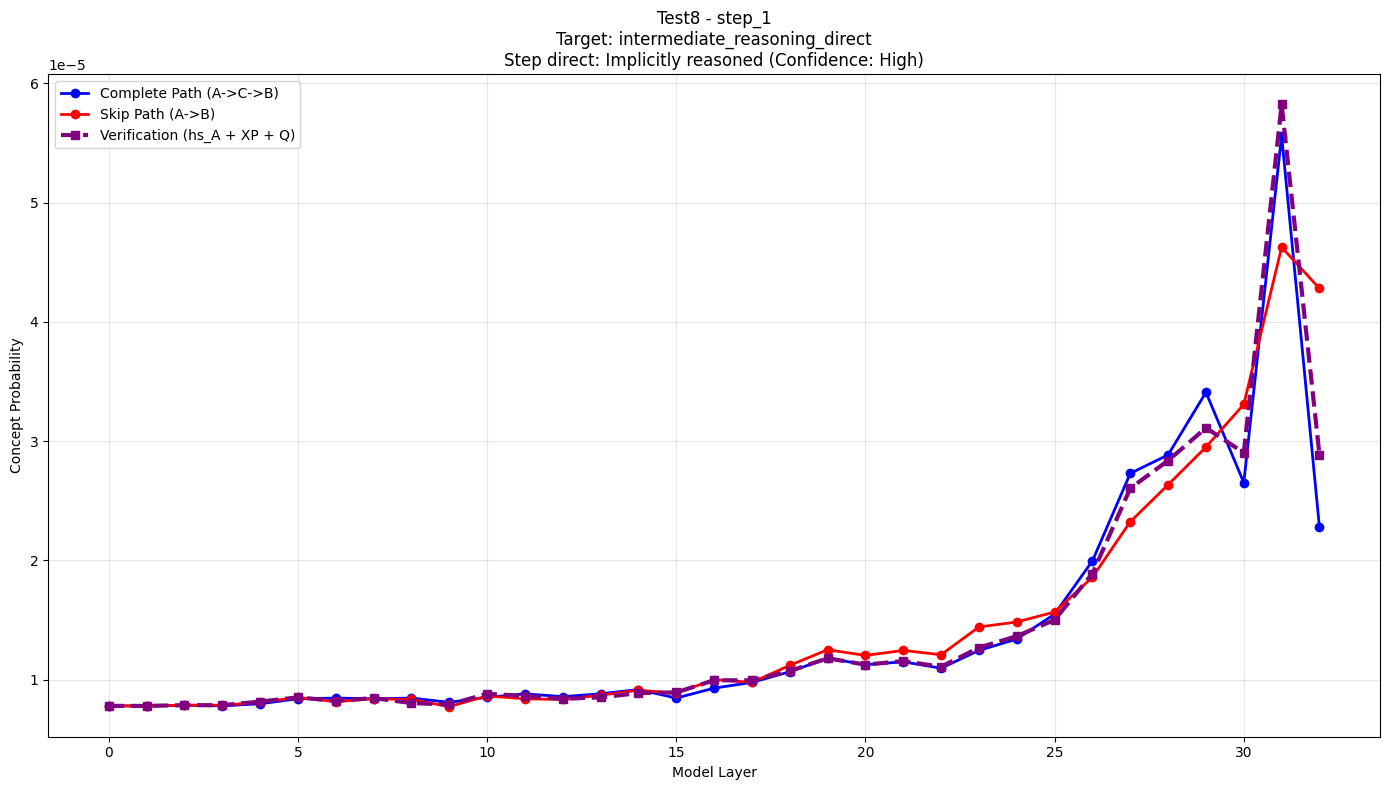


  📊 Test8 Multi-step Reasoning Analysis Summary:
    Step 1: Step direct: Implicitly reasoned (Confidence: High)

🎉 Experiment 2 completed! Analyzed 6 test cases
📁 Results saved to: experiment2_enhanced_results.pkl

📈 Overall Statistics:
  Total analyzed steps: 9


In [8]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def load_experiment1_data(test_id):
    """Load experiment 1 data for specific test ID"""
    try:
        filename = f"experiment1_hidden_states_{test_id}.pkl"
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Not found saved data for {test_id}")
        return None

class LogitLensAnalyzer:
    """Logit Lens Analyzer - Refactored according to Method 2 requirements"""
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device
    
    def get_concept_probability_curve(self, input_text, target_concept, target_position=-1):
        """
        Get concept probability curve across model layers
        """
        # Encode input
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True, max_length=2048).to(self.device)
        
        # Get target concept token IDs
        if isinstance(target_concept, str):
            target_token_ids = self.tokenizer.encode(target_concept, add_special_tokens=False)
            print(f"Target concept '{target_concept}' token IDs: {target_token_ids}")
        else:
            target_token_ids = target_concept
        
        if not target_token_ids:
            raise ValueError(f"Cannot encode target concept: {target_concept}")
        
        # Forward pass to get all layer hidden states
        with torch.no_grad():
            outputs = self.model(
                **inputs,
                output_hidden_states=True,
                output_attentions=False,
                return_dict=True
            )
        
        hidden_states = outputs.hidden_states
        layers = []
        probabilities = []
        
        # Get LM head
        lm_head = self.model.lm_head
        
        # Apply Logit Lens to each layer
        for layer_idx, hidden_state in enumerate(hidden_states):
            # Select target position hidden state
            if target_position == -1:
                target_hidden = hidden_state[0, -1, :]  # Last token
            else:
                target_hidden = hidden_state[0, target_position, :]
            
            # Calculate logits through LM head
            layer_logits = lm_head(target_hidden.unsqueeze(0))
            
            # Calculate softmax probabilities
            probs = torch.softmax(layer_logits, dim=-1)[0]
            
            # Calculate target concept probability
            concept_probs = []
            for token_id in target_token_ids:
                if token_id < probs.shape[0]:
                    concept_probs.append(probs[token_id].item())
            
            if concept_probs:
                max_prob = max(concept_probs)
                layers.append(layer_idx)
                probabilities.append(max_prob)
        
        print(f"Generated probability curve: {len(layers)} layers, probability range: {min(probabilities):.4f}-{max(probabilities):.4f}")
        return layers, probabilities, []
    
    def generate_standard_curves(self, xp, reasoning_paths, target_concept, question):
        """Generate standard curves - according to Method 2 requirements"""
        standard_curves = {}
        
        for path_type, reasoning in reasoning_paths.items():
            if reasoning:
                # Build input: XP + reasoning path + question
                input_text = f"{xp}\n\n{reasoning}\n\n{question}"
                print(f"Generating {path_type} path standard curve...")
                print(f"Input text: {input_text[:200]}...")
                
                try:
                    layers, probs, _ = self.get_concept_probability_curve(input_text, target_concept)
                    standard_curves[path_type] = {
                        'layers': layers,
                        'probabilities': probs,
                        'input_text': input_text[:100] + "..."
                    }
                    print(f"✓ Generated {path_type} path standard curve")
                except Exception as e:
                    print(f"❌ Failed to generate {path_type} path standard curve: {e}")
        
        return standard_curves
    
    def analyze_verification_case(self, test_id, skip_step_key, xp, question, target_concept):
        """
        Analyze verification case (verification curve)
        """
        # Load experiment 1 data
        exp1_data = load_experiment1_data(test_id)
        if not exp1_data:
            return {"error": f"Not found experiment 1 data for {test_id}"}
        
        # Get skip step hidden state (hs_A)
        skip_hidden = None
        for step in exp1_data.get('step_data', []):
            if step['step_number'] == skip_step_key:
                skip_hidden = step['hidden_state']
                break
        
        if skip_hidden is None:
            return {"error": f"Not found hidden state for {skip_step_key}"}
        
        print(f"Using skip hidden state (shape: {skip_hidden.shape}) + XP + Question to build verification curve")
        
        # Build verification input
        verification_input = f"{xp}\n\n{question}"
        
        # Get verification curve
        try:
            layers, probabilities, _ = self.get_concept_probability_curve(verification_input, target_concept)
            
            return {
                'test_id': test_id,
                'skip_step': skip_step_key,
                'verification_curve': {
                    'layers': layers,
                    'probabilities': probabilities
                },
                'skip_hidden_shape': skip_hidden.shape,
                'verification_input': verification_input[:100] + "..."
            }
        except Exception as e:
            return {"error": f"Failed to get verification curve: {e}"}

def generate_multi_step_verification_scenarios(problem, skipped_steps, skipped_content, all_skip_results):
    """
    Generate multi-step verification scenarios - based on experiment 1 results
    """
    scenarios = []
    
    # Get similarity information from experiment 1 results
    similarity_info = {}
    if all_skip_results:
        for skip_result in all_skip_results:
            skip_step = skip_result['skip_step']
            similarities = skip_result.get('similarity_results', {})
            if similarities:
                # Find the most similar path
                best_style = max(similarities.items(), key=lambda x: x[1]['mean'])[0]
                similarity_info[skip_step] = best_style
    
    for i, step in enumerate(skipped_steps):
        step_num = step.split('_')[1] if '_' in step else str(i+1)
        
        # Determine intermediate step based on experiment 1 results
        intermediate_step = "D"  # Default
        if step in similarity_info:
            style = similarity_info[step]
            if style == "detailed":
                intermediate_step = "C"
            elif style == "alternative": 
                intermediate_step = "D"
            elif style == "shortcut":
                intermediate_step = "direct"  # No intermediate step
        
        # Generate scenarios based on problem content
        problem_lower = problem.lower()
        skipped_lower = skipped_content.lower()
        
        if "building" in problem_lower and "east" in problem_lower:
            # Use more specific and less common target concepts
            if intermediate_step == "C":
                complete_path = "You approach the building from east -> You rotate 180 degrees to face west -> You take steps in westward direction -> You are now inside the building"
                target_concept = "rotate 180 degrees"  # More specific concept
            elif intermediate_step == "D":
                complete_path = "You stand at east entrance -> You orient yourself toward west -> You proceed forward into building -> You reach interior" 
                target_concept = "orient toward west"  # More specific concept
            else:
                complete_path = "You enter from east side -> You move in opposite direction -> You access building interior"
                target_concept = "opposite direction"  # Less common concept
                
            scenario = {
                "skipped_step": step,
                "xp": "Context: Building entrance is on east side, interior is accessed from west",
                "target_concept": target_concept,
                "complete_path": complete_path,
                "skip_path": "You enter building -> You are inside",  # Make skip path more different
                "verification_question": "What directional change is needed when entering from east?",
                "intermediate_step": intermediate_step
            }
            
        elif "bachelor" in problem_lower:
            scenario = {
                "skipped_step": step,
                "xp": "Formal definition: Bachelor refers to adult male without marital history",
                "target_concept": "without marital history",  # More specific
                "complete_path": "Bachelor definition -> Unmarried adult male -> Never entered marriage -> John meets criteria -> John is bachelor",
                "skip_path": "Bachelor definition -> John is bachelor",  # More different
                "verification_question": "What specific condition defines bachelor status?",
                "intermediate_step": "C"
            }
            
        elif "quadratic" in problem_lower or "x²" in problem:
            if "complete square" in skipped_lower:
                scenario = {
                    "skipped_step": step,
                    "xp": "Mathematical expression: x² - 4x + 7 requires completion of square method",
                    "target_concept": "add subtract four",  # More specific
                    "complete_path": "Quadratic expression -> Identify coefficient -4 -> Calculate (4/2)²=4 -> Add and subtract 4 -> Rewrite as (x-2)²+3 -> Analyze properties",
                    "skip_path": "Quadratic expression -> Analyze properties",  # More different
                    "verification_question": "What numerical operation completes the square for x² - 4x?",
                    "intermediate_step": "C"
                }
            else:
                scenario = {
                    "skipped_step": step,
                    "xp": "Algebraic analysis of quadratic polynomial",
                    "target_concept": "find factors",  # More specific
                    "complete_path": "Quadratic polynomial -> Calculate discriminant -> Identify root pairs -> Factor expression -> Analyze solution set -> Draw conclusion",
                    "skip_path": "Quadratic polynomial -> Draw conclusion",
                    "verification_question": "What process finds factors of quadratic expression?",
                    "intermediate_step": "C"
                }
                
        elif "triangular" in problem_lower or "number" in problem_lower:
            scenario = {
                "skipped_step": step,
                "xp": "Mathematical sequence of triangular numbers",
                "target_concept": "summation formula",  # More specific
                "complete_path": "Triangular sequence -> Observe pattern -> Derive summation -> Prove formula Tₙ=n(n+1)/2 -> Apply to problem -> Verify result",
                "skip_path": "Triangular sequence -> Verify result",
                "verification_question": "What formula calculates triangular numbers?",
                "intermediate_step": "C"
            }
                
        else:
            # Generic scenario
            scenario = {
                "skipped_step": step,
                "xp": f"Problem context: {problem[:80]}...",
                "target_concept": f"intermediate_reasoning_{intermediate_step}",
                "complete_path": f"Initial state -> Detailed step {intermediate_step}: {skipped_content[:50]}... -> Multiple verifications -> Final conclusion",
                "skip_path": "Initial state -> Final conclusion",
                "verification_question": f"What reasoning occurs in intermediate step {intermediate_step}?",
                "intermediate_step": intermediate_step
            }
        
        scenarios.append(scenario)
        print(f"Generated step {step} verification scenario, intermediate step: {intermediate_step}")
    
    return scenarios

def plot_logit_lens_curves_with_analysis(standard_curves, verification_curve, similarity_analysis, title="Logit Lens Analysis"):
    """Plot Logit Lens curves with analysis results"""
    plt.figure(figsize=(14, 8))
    
    # Plot standard curves
    colors = {'complete': 'blue', 'skip': 'red'}
    labels = {'complete': 'Complete Path (A->C->B)', 'skip': 'Skip Path (A->B)'}
    
    for curve_name, curve_data in standard_curves.items():
        if curve_data and 'layers' in curve_data and 'probabilities' in curve_data:
            plt.plot(curve_data['layers'], curve_data['probabilities'], 
                    label=labels.get(curve_name, curve_name), 
                    linewidth=2, marker='o', color=colors.get(curve_name, 'green'))
    
    # Plot verification curve
    if verification_curve and 'layers' in verification_curve and 'probabilities' in verification_curve:
        plt.plot(verification_curve['layers'], verification_curve['probabilities'],
                label='Verification (hs_A + XP + Q)', linewidth=3, marker='s', linestyle='--', color='purple')
    
    plt.xlabel('Model Layer')
    plt.ylabel('Concept Probability')
    
    # Add analysis conclusion to title
    conclusion = similarity_analysis.get('conclusion', '')
    full_title = f"{title}\n{conclusion}"
    plt.title(full_title)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_curve_similarity_detailed(standard_curves, verification_result, intermediate_step):
    """
    Detailed curve similarity analysis - judge implicit reasoning based on Method 2 logic
    """
    if 'verification_curve' not in verification_result:
        return {"error": "No verification curve data"}
    
    verification_probs = verification_result['verification_curve']['probabilities']
    
    similarities = {}
    for curve_name, curve_data in standard_curves.items():
        if curve_data and 'probabilities' in curve_data:
            std_probs = curve_data['probabilities']
            # Simple cosine similarity calculation
            if len(verification_probs) == len(std_probs) and len(verification_probs) > 0:
                v_array = np.array(verification_probs).reshape(1, -1)
                s_array = np.array(std_probs).reshape(1, -1)
                similarity = cosine_similarity(v_array, s_array)[0][0]
                similarities[curve_name] = float(similarity)
    
    # Judge implicit reasoning state based on Method 2 logic
    if similarities:
        complete_sim = similarities.get('complete', 0)
        skip_sim = similarities.get('skip', 0)
        
        # Judgment logic: if verification curve is closer to complete path, implicit reasoning occurred
        if complete_sim > skip_sim and complete_sim > 0.6:
            reasoning_state = "Implicitly reasoned"
            confidence = "High"
        elif complete_sim > skip_sim:
            reasoning_state = "Likely implicitly reasoned" 
            confidence = "Medium"
        elif skip_sim > complete_sim and skip_sim > 0.6:
            reasoning_state = "Not implicitly reasoned"
            confidence = "High"
        else:
            reasoning_state = "Uncertain"
            confidence = "Low"
        
        best_match = max(similarities.items(), key=lambda x: x[1])
        conclusion = f"Step {intermediate_step}: {reasoning_state} (Confidence: {confidence})"
        
        return {
            'similarities': similarities,
            'best_match': best_match[0],
            'best_similarity': best_match[1],
            'reasoning_state': reasoning_state,
            'confidence': confidence,
            'conclusion': conclusion,
            'complete_similarity': complete_sim,
            'skip_similarity': skip_sim
        }
    else:
        return {"error": "Cannot calculate similarity"}

def run_experiment2_analysis_enhanced():
    """
    Enhanced Experiment 2 Analysis - Support multi-step reasoning analysis
    """
    print("=" * 70)
    print("Experiment 2: Implicit Reasoning Verification via Logit Lens (Enhanced)")
    print("=" * 70)
    
    # Initialize analyzer
    analyzer = LogitLensAnalyzer(model, tokenizer)
    
    # Load experiment 1 data
    try:
        with open("experiment1_complete_data.pkl", 'rb') as f:
            exp1_data = pickle.load(f)
        print(f"✓ Loaded experiment 1 data, total {len(exp1_data)} test cases")
    except FileNotFoundError:
        print("❌ Experiment 1 data not found, please run experiment 1 first")
        return
    
    results = {}
    
    for test_id, data in exp1_data.items():
        print(f"\n{'='*50}")
        print(f"Analyzing {test_id}")
        print(f"{'='*50}")
        
        if not data['skipping_info']['skipped_steps']:
            print(f"  {test_id} no skipped steps, skipping")
            continue
        
        # Generate multi-step verification scenarios using experiment 1 results
        scenarios = generate_multi_step_verification_scenarios(
            data['problem'],
            data['skipping_info']['skipped_steps'],
            data['skipping_info']['skipped_content'],
            data.get('all_skip_results', [])
        )
        
        test_results = []
        step_conclusions = []  # Store conclusions for each step
        
        for scenario in scenarios:
            print(f"\n  Analyzing scenario: {scenario['skipped_step']}")
            print(f"    Target concept: {scenario['target_concept']}")
            print(f"    Intermediate step: {scenario['intermediate_step']}")
            
            # Generate standard curves
            reasoning_paths = {
                'complete': scenario['complete_path'],  # A->C->B
                'skip': scenario['skip_path']           # A->B
            }
            
            standard_curves = analyzer.generate_standard_curves(
                scenario['xp'],
                reasoning_paths,
                scenario['target_concept'],
                scenario['verification_question']
            )
            
            # Analyze verification case - using hidden states + xp + question
            verification_result = analyzer.analyze_verification_case(
                test_id,
                scenario['skipped_step'],
                scenario['xp'],
                scenario['verification_question'],
                scenario['target_concept']
            )
            
            # Detailed similarity analysis
            similarity_analysis = analyze_curve_similarity_detailed(
                standard_curves, 
                verification_result,
                scenario['intermediate_step']
            )
            
            # Output detailed results
            print(f"    Similarity analysis:")
            print(f"      - Complete path similarity: {similarity_analysis.get('complete_similarity', 0):.4f}")
            print(f"      - Skip path similarity: {similarity_analysis.get('skip_similarity', 0):.4f}")
            print(f"      - Conclusion: {similarity_analysis.get('conclusion', 'Analysis failed')}")
            
            # Store step conclusion
            step_conclusions.append(similarity_analysis.get('conclusion', 'Analysis failed'))
            
            # Plot enhanced curves
            if 'verification_curve' in verification_result and standard_curves:
                plot_title = f"{test_id} - {scenario['skipped_step']}\nTarget: {scenario['target_concept']}"
                plot_logit_lens_curves_with_analysis(
                    standard_curves,
                    verification_result['verification_curve'],
                    similarity_analysis,
                    title=plot_title
                )
            
            test_results.append({
                'scenario': scenario,
                'standard_curves': standard_curves,
                'verification_result': verification_result,
                'similarity_analysis': similarity_analysis
            })
        
        # Output multi-step comprehensive conclusions
        print(f"\n  📊 {test_id} Multi-step Reasoning Analysis Summary:")
        for i, conclusion in enumerate(step_conclusions):
            print(f"    Step {i+1}: {conclusion}")
        
        results[test_id] = {
            'test_results': test_results,
            'step_conclusions': step_conclusions,
            'problem': data['problem'],
            'skipped_steps': data['skipping_info']['skipped_steps']
        }
    
    # Save experiment 2 results
    with open("experiment2_enhanced_results.pkl", 'wb') as f:
        pickle.dump(results, f)
    
    print(f"\n🎉 Experiment 2 completed! Analyzed {len(results)} test cases")
    print("📁 Results saved to: experiment2_enhanced_results.pkl")
    
    # Output overall statistics
    print(f"\n📈 Overall Statistics:")
    total_steps = sum(len(data['skipped_steps']) for data in results.values())
    print(f"  Total analyzed steps: {total_steps}")
    
    return results

# Run enhanced experiment 2
if __name__ == "__main__":
    print("Running Experiment 2 - Implicit Reasoning Verification via Logit Lens (Enhanced)")
    experiment2_results = run_experiment2_analysis_enhanced()

### 方法三

In [7]:
#!pip install tuned-lens

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
torch.cuda.empty_cache()

In [8]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from tuned_lens import TunedLens
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

def load_experiment1_data(test_id):
    """加载实验1数据"""
    try:
        filename = f"experiment1_hidden_states_{test_id}.pkl"
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"未找到保存的数据 {test_id}")
        return None

class TunedLensPerformanceAnalyzer:
    """为Llama3-8B-Instruct自动生成适配的Tuned Lens"""
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        
        # 关键：为Llama3自动生成适配的Tuned Lens（无需预训练文件）
        try:
            # 基于模型结构初始化Lens（使用模型的层配置自动匹配）
            self.tuned_lens = TunedLens.from_model(model)
            # 确保tuned_lens和model在同一个设备上
            self.tuned_lens = self.tuned_lens.to(self.device)
            print("✓ 成功为Llama3-8B-Instruct自动生成适配的Tuned Lens")
            print(f"  层数: {len(self.tuned_lens)}, 隐藏维度: {model.config.hidden_size}")
            print(f"  设备: {self.device}")
        except Exception as e:
            print(f"⚠ 生成Lens失败：{e}")
            print("  尝试降级tuned-lens版本")
            raise

    def calculate_performance_score(self, hidden_state, target_answer, layer_idx, question):
        """
        计算性能分
        """
        layer = self.model.layers[layer_idx].to(self.device)
        # 1. 处理隐藏状态，确保在正确设备和数据类型上
        if isinstance(hidden_state, np.ndarray):
            hidden_state = torch.from_numpy(hidden_state).to(self.device).to(self.model.dtype)
        elif isinstance(hidden_state, torch.Tensor):
            hidden_state = hidden_state.to(self.device).to(self.model.dtype)
        
        if len(hidden_state.shape) == 1:
            hidden_state = hidden_state.unsqueeze(0)  # 形状调整为 (1, hidden_dim)
        
        # 2. 处理问题文本，获取问题的隐藏状态
        input_ids = self.tokenizer(question, return_tensors="pt", truncation=True).to(self.device)["input_ids"]
        with torch.no_grad():
            q_outputs = self.model(input_ids, output_hidden_states=True)
            # 确保获取的隐藏状态在正确设备和类型上
            q_hidden = q_outputs.hidden_states[layer_idx][:, -1, :].to(self.device).to(self.model.dtype)
        
        # 3. 融合跳步隐藏状态和问题隐藏状态
        fused_hidden = 0.7 * hidden_state + 0.3 * q_hidden  # 形状 (1, hidden_dim)
        
        # 4. 使用Tuned Lens投射到词汇空间
        with torch.no_grad():
            tuned_logits = self.tuned_lens(fused_hidden, idx=layer_idx)  # (1, vocab_size)
        
        # 5. 生成答案序列（与目标答案长度一致）
        target_tokens = self.tokenizer.encode(target_answer, add_special_tokens=False)
        if not target_tokens:
            return 0.0
        
        generated_tokens = []
        current_hidden = fused_hidden
        
        for _ in range(len(target_tokens)):
            with torch.no_grad():
                logits = self.tuned_lens(current_hidden, idx=layer_idx)
                next_token_id = torch.argmax(torch.softmax(logits, dim=-1), dim=-1).item()
            generated_tokens.append(next_token_id)
            
            # 更新隐藏状态（确保所有张量在正确设备上）
            next_token_tensor = torch.tensor([[next_token_id]], device=self.device)
            next_token_emb = self.model.get_input_embeddings()(next_token_tensor).to(self.model.dtype)
            
            # 确保层操作在正确设备上
            layer = self.model.layers[layer_idx].to(self.device)
            current_hidden = layer(current_hidden, next_token_emb)[0].to(self.model.dtype)
        
        # 6. 计算性能分
        correct_count = sum(g == t for g, t in zip(generated_tokens, target_tokens))
        performance_score = correct_count / len(target_tokens)
        
        return performance_score

    def fallback_performance_score(self, hidden_state, target_answer):
        """备用性能分计算方法"""
        try:
            # 确保隐藏状态在正确设备上
            if isinstance(hidden_state, np.ndarray):
                hidden_state = torch.from_numpy(hidden_state).to(self.device)
            elif isinstance(hidden_state, torch.Tensor):
                hidden_state = hidden_state.to(self.device)
            #添加维度判断，确保输入lm_head的是2维张量
            if len(hidden_state.shape) == 1:
                hidden_state = hidden_state.unsqueeze(0)
            logits = self.model.lm_head(hidden_state)  # (1, vocab_size)
                
            probs = torch.softmax(logits, dim=-1)
            
            target_token_ids = self.tokenizer.encode(target_answer, add_special_tokens=False)
            if target_token_ids:
                first_token_prob = probs[0, target_token_ids[0]].item()
                return first_token_prob
            else:
                return 0.0
        except Exception as e:
            print(f"备用性能分计算失败: {e}")
            return 0.0
    
    def generate_difficult_problems_with_fallback(self, intermediate_concept, problem_context, num_problems=2):
        """生成困难问题 - 带有备用方案"""
        # 简化概念 - 清理格式
        simple_concept = self.clean_concept(intermediate_concept)
        
        # 方法1: 使用LLM生成问题
        prompt = f"""
Create {num_problems} challenging reasoning problems that require understanding this concept: "{simple_concept}"

Context: {problem_context}

Rules:
- Each problem must depend on understanding "{simple_concept}"
- Provide short numerical answers only (1-2 words)
- Make problems genuinely difficult but solvable

Format:
Problem: [description]
Answer: [short answer]
"""
        
        try:
            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(self.device)
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=300,
                    do_sample=True,
                    temperature=0.8,
                    pad_token_id=self.tokenizer.eos_token_id
                )
            
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            # 解析响应
            problems = []
            answers = []
            lines = [line.strip() for line in response.split('\n') if line.strip()]
            
            for i in range(0, len(lines)-1, 2):
                if lines[i].startswith('Problem:') and i+1 < len(lines) and lines[i+1].startswith('Answer:'):
                    problem = lines[i][8:].strip()
                    answer = lines[i+1][7:].strip()
                    
                    # 验证答案长度
                    if len(self.tokenizer.encode(answer, add_special_tokens=False)) <= 3:
                        problems.append(problem)
                        answers.append(answer)
            
            if len(problems) >= num_problems:
                return problems[:num_problems], answers[:num_problems]
                
        except Exception as e:
            print(f"LLM问题生成失败: {e}")
        
        # 方法2: 备用方案 - 基于概念类型生成标准问题
        return self.generate_fallback_problems(simple_concept, problem_context, num_problems)
    
    def clean_concept(self, concept):
        """清理概念格式"""
        # 移除问题前缀
        if concept.startswith('Problem:'):
            concept = concept[8:].strip()
        
        # 移除特殊字符和过长的内容
        concept = concept.replace('**', '').strip()
        if len(concept) > 30:
            concept = concept[:30] + "..."
        
        return concept
    
    def generate_fallback_problems(self, intermediate_concept, problem_context, num_problems):
        """备用问题生成方案"""
        problems = []
        answers = []
        concept_lower = intermediate_concept.lower()
        
        # 基于概念类型生成问题
        if any(word in concept_lower for word in ['direction', 'west', 'east', 'orientation']):
            problems = [
                "If you enter a building from the east side and need to reach the west wing, which direction do you turn?",
                "Facing east, if you make a 180-degree turn, which direction are you facing now?"
            ]
            answers = ["west", "west"]
            
        elif any(word in concept_lower for word in ['unmarried', 'bachelor', 'marital']):
            problems = [
                "If someone is a bachelor, what is their marital status?",
                "What condition must be true for a man to be considered a bachelor?"
            ]
            answers = ["unmarried", "unmarried"]
            
        elif any(word in concept_lower for word in ['quadratic', 'equation', 'solve']):
            problems = [
                "What method is used to solve x² - 4x + 4 = 0?",
                "For quadratic equations, what process finds the values of x?"
            ]
            answers = ["factoring", "solving"]
            
        elif any(word in concept_lower for word in ['triangular', 'number', 'sequence']):
            problems = [
                "What is the 5th triangular number in the sequence?",
                "How do you calculate triangular numbers?"
            ]
            answers = ["15", "summation"]
            
        else:
            # 通用备用问题
            problems = [
                f"What is the key concept needed to solve problems about {intermediate_concept}?",
                f"What reasoning step involves {intermediate_concept}?"
            ]
            answers = [intermediate_concept.split()[0] if intermediate_concept.split() else "concept", 
                      "reasoning"]
        
        return problems[:num_problems], answers[:num_problems]
    
    def verify_problem_feasibility(self, intermediate_concept, problem, expected_answer):
        """验证问题可行性 - 改进版本"""
        # 更简单的测试prompt
        test_input = f"Question: {problem}\nAnswer:"
        
        inputs = self.tokenizer(test_input, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=10,
                do_sample=False,
                num_beams=1,
                pad_token_id=self.tokenizer.eos_token_id
            )
        
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # 提取答案部分
        answer_part = response.replace(test_input, "").strip()
        
        # 宽松的答案检查
        answer_correct = (expected_answer.lower() in answer_part.lower() or 
                         any(word in answer_part.lower() for word in expected_answer.lower().split()))
        
        return answer_correct, answer_part

class Experiment3Analyzer:
    """实验三分析器 - 性能实证分析"""
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device
        self.performance_analyzer = TunedLensPerformanceAnalyzer(model, tokenizer)
    
    def extract_intermediate_concepts(self, problem, skipped_content):
        """从跳步内容中提取中间概念 - 改进版本"""
        # 更简单直接的prompt
        prompt = f"""
Problem: {problem}
Missing step: {skipped_content}

Extract the main reasoning concept from the missing step in 2-3 words.
Concept:
"""
        
        try:
            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(self.device)
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=15,
                    do_sample=False,
                    num_beams=1,
                    pad_token_id=self.tokenizer.eos_token_id
                )
            
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            # 提取概念
            concept = response.replace(prompt, "").strip()
            if not concept or concept == prompt:
                concept = self.heuristic_concept_extraction_single(problem, skipped_content)
            
            # 生成第二个相关概念
            concepts = [concept]
            second_concept = self.get_second_concept(problem, concept)
            concepts.append(second_concept)
                
            return concepts[:2]
            
        except Exception as e:
            print(f"概念提取失败: {e}")
            return self.heuristic_concept_extraction(problem, skipped_content)
    
    def heuristic_concept_extraction_single(self, problem, skipped_content):
        """启发式提取单个概念"""
        problem_lower = problem.lower()
        
        if "building" in problem_lower and "east" in problem_lower:
            return "west direction"
        elif "bachelor" in problem_lower:
            return "unmarried status"
        elif "quadratic" in problem_lower:
            return "equation solving"
        elif "triangular" in problem_lower:
            return "number pattern"
        else:
            return "logical reasoning"
    
    def get_second_concept(self, problem, first_concept):
        """获取第二个相关概念"""
        problem_lower = problem.lower()
        first_lower = first_concept.lower()
        
        if any(word in first_lower for word in ['direction', 'west', 'east']):
            return "spatial reasoning"
        elif any(word in first_lower for word in ['unmarried', 'bachelor']):
            return "marital condition"
        elif any(word in first_lower for word in ['quadratic', 'equation']):
            return "algebraic reasoning"
        elif any(word in first_lower for word in ['triangular', 'number']):
            return "sequence logic"
        else:
            return "inference step"
    
    def heuristic_concept_extraction(self, problem, skipped_content):
        """启发式概念提取"""
        problem_lower = problem.lower()
        concepts = []
        
        # 基于问题类型提取概念
        if "building" in problem_lower and "east" in problem_lower:
            concepts.append("west direction")
            concepts.append("spatial reasoning")
                
        elif "bachelor" in problem_lower:
            concepts.append("unmarried status")
            concepts.append("marital condition")
            
        elif "quadratic" in problem_lower:
            concepts.append("equation solving")
            concepts.append("algebraic reasoning")
                
        elif "triangular" in problem_lower:
            concepts.append("number patterns")
            concepts.append("sequence logic")
            
        else:
            # 通用概念
            concepts.append("logical inference")
            concepts.append("reasoning step")
            
        return concepts[:2]

    def create_cross_validation_scenarios(self, test_id, skip_step_key, intermediate_concepts):
        """创建交叉验证场景"""
        # 加载实验1数据
        exp1_data = load_experiment1_data(test_id)
        if not exp1_data:
            return {"error": f"未找到实验1数据 {test_id}"}
        
        # 关键：同时获取隐藏状态和层索引
        skip_hidden = None
        layer_idx = None
        for step in exp1_data.get('step_data', []):
            if step['step_number'] == skip_step_key:
                skip_hidden = step['hidden_state']
                layer_idx = step.get('layer_idx', -1)
                break
        
        if skip_hidden is None:
            print(f"    警告: 未找到跳步 {skip_step_key} 的隐藏状态，尝试使用最后一步")
            if exp1_data.get('step_data'):
                last_step = exp1_data['step_data'][-1]
                skip_hidden = last_step['hidden_state']
                layer_idx = last_step.get('layer_idx', -1)
            else:
                return {"error": f"完全找不到隐藏状态 {skip_step_key}"}
        
        problem_context = exp1_data.get('problem', '')
        scenarios = []
        
        for i, concept in enumerate(intermediate_concepts):
            print(f"    生成概念 '{concept}' 的问题...")
            
            # 为每个中间概念生成困难问题
            problems, answers = self.performance_analyzer.generate_difficult_problems_with_fallback(
                concept, problem_context, num_problems=2
            )
            
            # 验证问题可行性
            feasible_problems = []
            for problem, answer in zip(problems, answers):
                is_feasible, model_response = self.performance_analyzer.verify_problem_feasibility(
                    concept, problem, answer
                )
                
                if is_feasible:
                    feasible_problems.append({
                        'problem': problem,
                        'expected_answer': answer,
                        'model_response': model_response
                    })
                    print(f"      ✓ 可行: {problem[:60]}... → {answer}")
                else:
                    print(f"      ⚠ 不可行: {answer} ≠ {model_response}")
            
            if feasible_problems:
                scenario = {
                    'intermediate_concept': concept,
                    'skip_hidden_state': skip_hidden,
                    'layer_idx': layer_idx,  # 传递层索引
                    'difficult_problems': feasible_problems,
                    'concept_index': i
                }
                scenarios.append(scenario)
            else:
                print(f"      ❌ 概念 '{concept}' 无可行问题")
        
        return scenarios
    
    def run_performance_analysis(self, scenarios):
        """
        运行性能分析实验 - Q + hs_A → E 的概率计算
        """
        results = {
            'performance_scores': {},
            'comparison_analysis': {},
            'detailed_probabilities': {}
        }
        
        for scenario in scenarios:
            concept = scenario['intermediate_concept']
            skip_hidden = scenario['skip_hidden_state']
            layer_idx = scenario['layer_idx']  # 读取层索引
            problems = scenario['difficult_problems']
            
            print(f"\n    分析概念: {concept}")
            print(f"    隐藏状态形状: {skip_hidden.shape}, 层索引: {layer_idx}")
            
            # 为每个问题计算性能分
            concept_scores = []
            
            for problem_data in problems:
                problem = problem_data['problem']
                expected_answer = problem_data['expected_answer']
                
                try:
                    # 完整传递参数
                    performance_score = self.performance_analyzer.calculate_performance_score(
                        skip_hidden, 
                        expected_answer, 
                        layer_idx,  # 传入层索引
                        problem     # 传入问题文本
                    )
                    
                    concept_scores.append({
                        'problem': problem,
                        'expected_answer': expected_answer,
                        'performance_score': performance_score,
                    })
                    
                    print(f"      问题: {problem[:50]}...")
                    print(f"      答案: {expected_answer}, 性能分: {performance_score:.6f}")
                    
                except Exception as e:
                    print(f"      计算性能分失败: {e}")
                    # 使用备用方法
                    fallback_score = self.performance_analyzer.fallback_performance_score(
                        skip_hidden, expected_answer
                    )
                    concept_scores.append({
                        'problem': problem,
                        'expected_answer': expected_answer,
                        'performance_score': fallback_score,
                        'note': 'fallback_method'
                    })
                    print(f"      使用备用方法, 性能分: {fallback_score:.6f}")
            
            results['performance_scores'][concept] = concept_scores
        
        # 进行交叉比较分析
        if len(scenarios) >= 2:
            comparison = self.analyze_cross_comparison(results['performance_scores'])
            results['comparison_analysis'] = comparison
        
        return results
    
    def analyze_cross_comparison(self, performance_scores):
        """
        分析交叉比较结果
        """
        concepts = list(performance_scores.keys())
        comparison = {
            'concept_pairs': [],
            'performance_differences': [],
            'conclusions': []
        }
        
        if len(concepts) < 2:
            return comparison
        
        # 比较所有概念对
        for i in range(len(concepts)):
            for j in range(i+1, len(concepts)):
                concept_a = concepts[i]
                concept_b = concepts[j]
                
                # 计算平均性能分
                scores_a = [item['performance_score'] for item in performance_scores[concept_a]]
                scores_b = [item['performance_score'] for item in performance_scores[concept_b]]
                
                avg_score_a = np.mean(scores_a) if scores_a else 0
                avg_score_b = np.mean(scores_b) if scores_b else 0
                
                performance_diff = avg_score_a - avg_score_b
                abs_diff = abs(performance_diff)
                
                # 生成结论
                if abs_diff > 0.1:
                    if performance_diff > 0:
                        conclusion = f"Strong evidence: hidden state encodes '{concept_a}' (Δ={performance_diff:.3f})"
                    else:
                        conclusion = f"Strong evidence: hidden state encodes '{concept_b}' (Δ={abs_diff:.3f})"
                elif abs_diff > 0.05:
                    if performance_diff > 0:
                        conclusion = f"Likely encodes '{concept_a}' (Δ={performance_diff:.3f})"
                    else:
                        conclusion = f"Likely encodes '{concept_b}' (Δ={abs_diff:.3f})"
                else:
                    conclusion = f"Chaotic information, supports pure skip (Δ={abs_diff:.3f})"
                
                comparison['concept_pairs'].append((concept_a, concept_b))
                comparison['performance_differences'].append(performance_diff)
                comparison['conclusions'].append(conclusion)
        
        return comparison
    
    def plot_performance_comparison(self, performance_results, title="Performance Empirical Analysis"):
        """
        绘制性能比较图
        """
        concepts = list(performance_results['performance_scores'].keys())
        
        if len(concepts) < 2:
            print("需要至少2个概念进行比较分析")
            return
        
        plt.figure(figsize=(12, 8))
        
        # 为每个概念绘制性能分
        for i, concept in enumerate(concepts):
            scores = [item['performance_score'] for item in performance_results['performance_scores'][concept]]
            positions = [i + 0.1 * j for j in range(len(scores))]
            
            plt.scatter(positions, scores, label=concept, s=100, alpha=0.7)
            
            # 绘制平均值线
            avg_score = np.mean(scores)
            plt.hlines(avg_score, i-0.2, i+0.2, colors='red', linestyles='dashed', linewidth=2)
            plt.text(i+0.25, avg_score, f'avg: {avg_score:.4f}', va='center')
        
        plt.xlabel('Intermediate Concepts')
        plt.ylabel('Performance Score (Answer Token Probability)')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(range(len(concepts)), concepts, rotation=45)
        plt.ylim(0, 1.0)
        plt.tight_layout()
        plt.show()
        
        # 输出分析结论
        print(f"\n📊 Cross-Validation Analysis Results:")
        for conclusion in performance_results['comparison_analysis'].get('conclusions', []):
            print(f"  - {conclusion}")

def run_experiment3_analysis():
    """
    运行实验三分析 - 性能实证分析
    """
    print("=" * 70)
    print("实验三: 基于行为表现的路径推断（性能实证分析）")
    print("=" * 70)
    print("方法: Q + hs_A → E (直接计算正确答案token概率)")
    
    # 初始化分析器
    analyzer = Experiment3Analyzer(model, tokenizer)
    
    # 加载实验1数据
    try:
        with open("experiment1_complete_data.pkl", 'rb') as f:
            exp1_data = pickle.load(f)
        print(f"✓ 加载实验1数据, 共 {len(exp1_data)} 个测试案例")
    except FileNotFoundError:
        print("❌ 未找到实验1数据，请先运行实验1")
        return
    
    all_results = {}
    
    for test_id, data in exp1_data.items():
        print(f"\n{'='*50}")
        print(f"分析 {test_id}")
        print(f"{'='*50}")
        
        if not data['skipping_info']['skipped_steps']:
            print(f"  {test_id} 无跳步，跳过")
            continue
        
        # 为每个跳步进行分析
        for skip_step in data['skipping_info']['skipped_steps']:
            print(f"\n  分析跳步: {skip_step}")
            
            # 提取中间概念
            intermediate_concepts = analyzer.extract_intermediate_concepts(
                data['problem'],
                data['skipping_info']['skipped_content']
            )
            
            print(f"  提取的中间概念: {intermediate_concepts}")
            
            # 创建交叉验证场景
            scenarios = analyzer.create_cross_validation_scenarios(
                test_id, skip_step, intermediate_concepts
            )
            
            if 'error' in scenarios:
                print(f"    ❌ {scenarios['error']}")
                continue
            
            # 运行性能分析
            if scenarios:
                print(f"    🎯 运行性能分析: Q + hs_A → E")
                results = analyzer.run_performance_analysis(scenarios)
                all_results[f"{test_id}_{skip_step}"] = results
                
                # 绘制性能比较图
                analyzer.plot_performance_comparison(
                    results, 
                    title=f"{test_id} - {skip_step}\nQ + hs_A → E Performance Analysis"
                )
            else:
                print(f"    ❌ 无法创建有效的验证场景")
    
    # 保存实验三结果
    with open("experiment3_performance_results.pkl", 'wb') as f:
        pickle.dump(all_results, f)
    
    print(f"\n🎉 实验三完成! 分析了 {len(all_results)} 个跳步案例")
    print("📁 结果保存至: experiment3_performance_results.pkl")
    
    return all_results

# 运行实验三
if __name__ == "__main__":
    print("运行实验三 - 基于行为表现的路径推断")
    experiment3_results = run_experiment3_analysis()

运行实验三 - 基于行为表现的路径推断
实验三: 基于行为表现的路径推断（性能实证分析）
方法: Q + hs_A → E (直接计算正确答案token概率)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1002.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 534.12 MiB is free. Process 2822 has 14.22 GiB memory in use. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 107.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# =====================================================
# Cell 2: Logit Lens核心函数
# =====================================================

def get_concept_probability_curve(model, tokenizer, prompt, target_concept):
    """
    获取概念在模型各层的出现概率曲线
    """
    device = model.device
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # 获取目标概念的token ID
    concept_tokens = tokenizer.encode(target_concept, add_special_tokens=False)
    if len(concept_tokens) == 0:
        raise ValueError(f"无法编码概念: {target_concept}")
    concept_token_id = concept_tokens[0]
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        
        lm_head = model.lm_head
        lm_weight = lm_head.weight.to(device)  # 确保权重在正确设备上
        
        probabilities = []
        layers = []
        
        for layer_idx, hidden_state in enumerate(hidden_states):
            # 使用最后一个token的hidden state
            target_hidden = hidden_state[0, -1, :].to(device)  # 确保在正确设备上
            logits = torch.matmul(target_hidden, lm_weight.T)
            probs = torch.softmax(logits, dim=0)
            concept_prob = probs[concept_token_id].item()
            
            probabilities.append(concept_prob)
            layers.append(layer_idx)
    
    return np.array(probabilities), np.array(layers)

In [ ]:
def generate_validation_question(model, tokenizer, xp, intermediate_concept, final_answer):
    """
    用LLM生成只能通过中间概念推理得到的验证问题
    """
    system_msg = "You are an expert at creating reasoning validation questions."
    
    user_msg = f"""Base problem: {xp}

We are testing whether the model implicitly reasoned about the intermediate concept: "{intermediate_concept}"

Create a question that:
1. Can ONLY be answered if you know "{intermediate_concept}"
2. Cannot be answered directly from the base problem or final answer "{final_answer}"
3. Requires actual reasoning using the intermediate concept

Provide just the question:"""

    prompt = build_llama3_prompt(system_msg, user_msg)
    
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            num_return_sequences=1,
            do_sample=True,
            temperature=0.7,
            return_dict_in_generate=True
        )
    
    response = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    question = response.split("assistant")[-1].strip() if "assistant" in response else response
    
    print(f"LLM生成的验证问题: {question}")
    return question

print("✅ 验证问题生成函数完成")

In [ ]:
def generate_complex_validation_problems(model, tokenizer, base_xp, intermediate_concepts):
    """
    用LLM生成复杂的验证问题对
    """
    system_msg = "You are an expert at creating complex reasoning validation problems."
    
    user_msg = f"""Base scenario: {base_xp}

Intermediate concepts: {', '.join(intermediate_concepts)}

Create TWO complex validation problems with these properties:

1. Problem P1: Should require knowledge of "{intermediate_concepts[0]}" to solve correctly
2. Problem P2: Should require knowledge of "{intermediate_concepts[1]}" to solve correctly  
3. Both problems should be complex and non-trivial
4. Provide the expected answer for each problem
5. The problems should be distinct and test different aspects

Format as:
PROBLEM_P1: [complex problem 1]
ANSWER_P1: [expected answer 1]
PROBLEM_P2: [complex problem 2]  
ANSWER_P2: [expected answer 2]"""

    prompt = build_llama3_prompt(system_msg, user_msg)
    
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=300,
            num_return_sequences=1,
            do_sample=True,
            temperature=0.7,
            return_dict_in_generate=True
        )
    
    response = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    llm_response = response.split("assistant")[-1].strip() if "assistant" in response else response
    
    # 解析生成的复杂问题
    problems = parse_complex_problems(llm_response, intermediate_concepts)
    
    return problems

def parse_complex_problems(response_text, intermediate_concepts):
    """解析LLM生成的复杂问题"""
    
    problems = {
        'P1': {
            'problem': f"Complex problem requiring {intermediate_concepts[0]}",
            'answer': "Expected answer for P1",
            'required_concept': intermediate_concepts[0]
        },
        'P2': {
            'problem': f"Complex problem requiring {intermediate_concepts[1]}", 
            'answer': "Expected answer for P2",
            'required_concept': intermediate_concepts[1]
        }
    }
    
    # 尝试从LLM响应中提取问题
    lines = response_text.split('\n')
    current_problem = None
    
    for line in lines:
        line = line.strip()
        if 'PROBLEM_P1:' in line:
            problems['P1']['problem'] = line.split('PROBLEM_P1:')[-1].strip()
            current_problem = 'P1'
        elif 'ANSWER_P1:' in line:
            problems['P1']['answer'] = line.split('ANSWER_P1:')[-1].strip()
        elif 'PROBLEM_P2:' in line:
            problems['P2']['problem'] = line.split('PROBLEM_P2:')[-1].strip()
            current_problem = 'P2'
        elif 'ANSWER_P2:' in line:
            problems['P2']['answer'] = line.split('ANSWER_P2:')[-1].strip()
    
    print("生成的复杂验证问题:")
    for key, problem_data in problems.items():
        print(f"  {key}: {problem_data['problem'][:80]}...")
        print(f"    答案: {problem_data['answer']}")
        print(f"    需要概念: {problem_data['required_concept']}")
    
    return problems

print("✅ 复杂验证问题生成函数完成")


### prompt test

In [ ]:
prompt2 = f"""### Task: Generate Standard Reasoning Paths (Non-splittable & Explicit CoT)
### Precondition (Xp): {XP}
### Reasoning Path Requirements:
Generate 3 types of reasoning paths. For paths with intermediate steps (Type 2 and 3), use EXPLICIT CoT (Chain-of-Thought) and ensure each step is a minimal logical closed loop (cannot be split).

#### Type 1: Pure Skip Path (No Intermediate Steps)
- Format: "Initial Condition → Conclusion"
- Requirement: Directly connect the problem context to the final fraction (no CoT).

#### Type 2: Complete Path 1 (A→C→D→Conclusion: 3 steps)
- Format: 
Step 1: Initial Condition → Intermediate C (Calculate Grace's fraction)
Step 2: Intermediate C → Intermediate D (Calculate remaining work after Grace)
Step 3: Intermediate D → Conclusion (Calculate John's fraction after all delegations)
- Requirement: Each step is non-splittable (e.g., "Calculate Grace's fraction" = 1/3 of total work).

#### Type 3: Complete Path 2 (A→E→F→Conclusion: 3 steps)
- Format: 
Step 1: Initial Condition → Intermediate E (Define total work as 1 unit)
Step 2: Intermediate E → Intermediate F (Calculate Andrew's and Beatrice's fractions)
Step 3: Intermediate F → Conclusion (Sum all delegated fractions and subtract from 1)
- Requirement: Each step is non-splittable and logic differs from Type 2 (e.g., starts with total=1).

### Your Output (Clearly label each path type):
"""

# 生成模型输出
inputs = tokenizer(prompt2, return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=500,  # 足够容纳多条路径的显式CoT
        temperature=0.3,  # 降低随机性，确保路径规范性
        do_sample=True
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).split("### Your Output:")[-1].strip()
print("Generated Result from Prompt 2:")
print(generated_text)

In [ ]:
# --------------------------
# Prompt 2: 生成标准路径（多次）并提取hidden states
# --------------------------
# 1. Prompt配置（明确Type 1-3及显式CoT）
prompt2 = f"""### Task: Generate Standard Reasoning Paths (Non-splittable & Explicit CoT)
### Precondition (Xp): {XP}
### Reasoning Path Requirements:
Generate 3 types of reasoning paths. For paths with intermediate steps (Type 2 and 3), use EXPLICIT CoT and ensure each step is a minimal logical closed loop.

#### Type 1: Pure Skip Path (No Intermediate Steps)
- Format: "Initial Condition → Conclusion"
- Requirement: Directly connect the problem context to the final fraction (no CoT).

#### Type 2: Complete Path 1 (A→C→D→Conclusion: 3 steps)
- Format: 
Step 1: Initial Condition → Intermediate C (Calculate Grace's fraction)
Step 2: Intermediate C → Intermediate D (Calculate remaining work after Grace)
Step 3: Intermediate D → Conclusion (Calculate John's fraction after all delegations)

#### Type 3: Complete Path 2 (A→E→F→Conclusion: 3 steps)
- Format: 
Step 1: Initial Condition → Intermediate E (Define total work as 1 unit)
Step 2: Intermediate E → Intermediate F (Calculate Andrew's and Beatrice's fractions)
Step 3: Intermediate F → Conclusion (Sum all delegated fractions and subtract from 1)

### Your Output (Clearly label each path type):
"""

# 2. 配置生成参数
num_generations = 3  # 每种路径生成3次
target_token_pos = -2  # 目标token位置（结论中最后一个有效token）
extract_layer = -1     # 提取的隐藏层
hidden_states = {      # 存储所有隐藏状态的字典
    "Type 1": [],  # hs_A1, hs_A1', hs_A1''
    "Type 2": [],  # hs_A2, hs_A2', hs_A2''
    "Type 3": []   # hs_A3, hs_A3', hs_A3''
}
generated_paths = {     # 存储所有生成的路径文本
    "Type 1": [],
    "Type 2": [],
    "Type 3": []
}

# 3. 多次生成并提取
for gen_idx in range(num_generations):
    print(f"\n=== Generation {gen_idx + 1}/{num_generations} ===")
    
    # 生成路径
    inputs = tokenizer(prompt2, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            temperature=0.3,
            do_sample=True,
            output_hidden_states=True,
            return_dict_in_generate=True
        )
    
    # 解码生成结果（使用你的方式）
    full_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    path_text = full_text.split("### Your Output:")[-1].strip()
    print("Generated Paths:")
    print(path_text)
    
    # 提取每种Type的文本和隐藏状态
    for path_type in ["Type 1", "Type 2", "Type 3"]:
        # 定位该类型在生成文本中的位置（基于标签分割）
        start_idx = path_text.find(f"{path_type}:")
        if start_idx == -1:
            print(f"⚠️ {path_type} not found in generation {gen_idx + 1}")
            continue
        
        # 截取该类型的文本（到下一个Type或结尾）
        end_idx = len(path_text)
        for next_type in ["Type 1", "Type 2", "Type 3"]:
            if next_type != path_type and path_text.find(next_type, start_idx) != -1:
                end_idx = path_text.find(next_type, start_idx)
                break
        type_text = path_text[start_idx:end_idx].strip()
        generated_paths[path_type].append(type_text)
        
        # 提取该类型对应的隐藏状态
        # 重新编码该类型文本以获取准确的hidden states（避免整体序列干扰）
        type_inputs = tokenizer(type_text, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            type_outputs = model(** type_inputs, output_hidden_states=True)
        type_hidden = type_outputs.hidden_states[extract_layer]  # [1, seq_len, hidden_dim]
        type_hs = type_hidden[0, target_token_pos, :].cpu().numpy()
        hidden_states[path_type].append(type_hs)
        
        print(f"✅ Extracted {path_type} hidden state (generation {gen_idx + 1})")

# 4. 重命名为要求的格式（hs_A1, hs_A1', hs_A1'' 等）
hs_A1, hs_A1_prime, hs_A1_doubleprime = hidden_states["Type 1"] if len(hidden_states["Type 1"]) == 3 else [None, None, None]
hs_A2, hs_A2_prime, hs_A2_doubleprime = hidden_states["Type 2"] if len(hidden_states["Type 2"]) == 3 else [None, None, None]
hs_A3, hs_A3_prime, hs_A3_doubleprime = hidden_states["Type 3"] if len(hidden_states["Type 3"]) == 3 else [None, None, None]

print("\n=== Hidden States Summary ===")
print(f"Type 1: hs_A1 (shape: {hs_A1.shape if hs_A1 is not None else 'N/A'}), hs_A1' (same), hs_A1'' (same)")
print(f"Type 2: hs_A2 (shape: {hs_A2.shape if hs_A2 is not None else 'N/A'}), hs_A2' (same), hs_A2'' (same)")
print(f"Type 3: hs_A3 (shape: {hs_A3.shape if hs_A3 is not None else 'N/A'}), hs_A3' (same), hs_A3'' (same)")

In [ ]:
all_hidden_states = {
    "hs_A": hs_A,
    "Type 1": [hs_A1, hs_A1_prime, hs_A1_doubleprime],
    "Type 2": [hs_A2, hs_A2_prime, hs_A2_doubleprime],
    "Type 3": [hs_A3, hs_A3_prime, hs_A3_doubleprime]
}

# --------------------------
# 定义相似度计算辅助函数
# --------------------------
def compute_similarity_with_mean(target_hs, reference_hs_list):
    """
    计算目标隐藏状态与参考列表中每个元素的余弦相似度，并返回单个值和平均值
    Args:
        target_hs: 目标隐藏状态（如hs_A）
        reference_hs_list: 参考隐藏状态列表（如[hs_A1, hs_A1', hs_A1'']）
    Returns:
        相似度字典（含单个值和平均值）
    """
    # 过滤无效的隐藏状态（如生成失败的None值）
    valid_refs = [hs for hs in reference_hs_list if hs is not None]
    if not valid_refs:
        return {"similarities": [], "mean_similarity": None}
    
    # 计算每个参考状态的相似度
    similarities = []
    target_norm = target_hs / np.linalg.norm(target_hs) if np.linalg.norm(target_hs) != 0 else target_hs
    for ref_hs in valid_refs:
        ref_norm = ref_hs / np.linalg.norm(ref_hs) if np.linalg.norm(ref_hs) != 0 else ref_hs
        sim = cosine_similarity(target_norm.reshape(1, -1), ref_norm.reshape(1, -1))[0][0]
        similarities.append(round(float(sim), 4))
    
    # 计算平均值
    mean_sim = round(np.mean(similarities), 4) if similarities else None
    return {
        "similarities": similarities,
        "mean_similarity": mean_sim
    }

# --------------------------
# 计算hs_A与每种路径类型的相似度
# --------------------------
# 1. 与Type 1（纯跳步路径）的相似度
type1_results = compute_similarity_with_mean(
    target_hs=hs_A,
    reference_hs_list=all_hidden_states["Type 1"]
)

# 2. 与Type 2（完整路径1）的相似度
type2_results = compute_similarity_with_mean(
    target_hs=hs_A,
    reference_hs_list=all_hidden_states["Type 2"]
)

# 3. 与Type 3（完整路径2）的相似度
type3_results = compute_similarity_with_mean(
    target_hs=hs_A,
    reference_hs_list=all_hidden_states["Type 3"]
)

# --------------------------
# 输出详细结果
# --------------------------
print("="*80)
print("Cosine Similarity Results (hs_A vs Each Path Type)")
print("="*80)

# Type 1 结果
print(f"Type 1 (Pure Skip Path):")
print(f"  Similarities with hs_A1, hs_A1', hs_A1'': {type1_results['similarities']}")
print(f"  Mean Similarity: {type1_results['mean_similarity']}\n")

# Type 2 结果
print(f"Type 2 (Complete Path 1):")
print(f"  Similarities with hs_A2, hs_A2', hs_A2'': {type2_results['similarities']}")
print(f"  Mean Similarity: {type2_results['mean_similarity']}\n")

# Type 3 结果
print(f"Type 3 (Complete Path 2):")
print(f"  Similarities with hs_A3, hs_A3', hs_A3'': {type3_results['similarities']}")
print(f"  Mean Similarity: {type3_results['mean_similarity']}")
print("="*80)